In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import utils

In [2]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [7]:
dsc_output = "/gpfs/commons/home/sbanerjee/simdata/sparse-regression/gradvi-experiments/linreg_corr_dense"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl   = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
msepkl    = os.path.join("../dsc/results", dsc_fname + "_mse.pkl")
dscout    = pd.read_pickle(dscoutpkl)

refresh_pickle = True

print(db)

/gpfs/commons/home/sbanerjee/simdata/sparse-regression/gradvi-experiments/linreg_corr_dense/linreg_corr_dense.db


In [8]:
target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [9]:
qp = dscQP(db, target, condition)
df = qp.output_table
df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file
0,1,blockdiag,200,blockdiag/blockdiag_1,0.4,blockdiag/blockdiag_1,"(500,10000)",mr_ash,mr_ash/blockdiag_1_mr_ash_1
1,1,blockdiag,200,blockdiag/blockdiag_2,0.6,blockdiag/blockdiag_2,"(500,10000)",mr_ash,mr_ash/blockdiag_2_mr_ash_1
2,1,blockdiag,200,blockdiag/blockdiag_3,0.8,blockdiag/blockdiag_3,"(500,10000)",mr_ash,mr_ash/blockdiag_3_mr_ash_1
3,2,blockdiag,200,blockdiag/blockdiag_4,0.4,blockdiag/blockdiag_4,"(500,10000)",mr_ash,mr_ash/blockdiag_4_mr_ash_1
4,2,blockdiag,200,blockdiag/blockdiag_5,0.6,blockdiag/blockdiag_5,"(500,10000)",mr_ash,mr_ash/blockdiag_5_mr_ash_1
...,...,...,...,...,...,...,...,...,...
175,9,blockdiag,200,blockdiag/blockdiag_26,0.6,blockdiag/blockdiag_26,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_26_lasso_...
176,9,blockdiag,200,blockdiag/blockdiag_27,0.8,blockdiag/blockdiag_27,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_27_lasso_...
177,10,blockdiag,200,blockdiag/blockdiag_28,0.4,blockdiag/blockdiag_28,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_28_lasso_...
178,10,blockdiag,200,blockdiag/blockdiag_29,0.6,blockdiag/blockdiag_29,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_29_lasso_...


In [10]:
def read_result(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data


def get_elbo_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['elbo_path'][-1]
    else:
        return data['model']['fit']['varobj'][-1]
    
def get_convergence_from_result(data, method, mrash_maxiter = 2000):
    '''
    1: converged
    2: abnormal termination
    3: number of iterations reached limit
    4: unknown
    '''
    if method.startswith('gradvi'):
        success = data['model']['success']
        if success:
            conv_status = 1
        else:
            conv_message = data['model']['fitobj']['message']
            if "ITERATIONS REACHED LIMIT" in conv_message:
                conv_status = 3
            elif "ABNORMAL_TERMINATION_IN_LNSRCH" in conv_message:
                conv_status = 2
            else:
                conv_status = 4
    else:
        niter = data['model']['fit']['iter']
        if niter == mrash_maxiter:
            conv_status = 3
        else:
            conv_status = 1
    return conv_status

def get_mse_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.pve", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    mse = dfrows[~dfrows['mse.err'].isnull()]['mse.err'].values
    if len(mse) == 1:
        return mse[0]
    else:
        print ("Error fetching value")
        return mse[0]
    
def get_elbodf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    elbo = get_elbo_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(elbo)    
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

def get_msedf(elbodf, dscdf):
    methods = [x[:-7] for x in list(elbodf.columns) if x.endswith("_status")]
    msedict = elbodf.to_dict()
    ikeys = list(msedict['simulate.sfix'].keys())
    for method in methods:
        for i in ikeys:
            mse = get_mse_from_dscout(dscout, 
                          msedict['simulate.sfix'][i], 
                          msedict['simulate.pve'][i],
                          msedict['DSC'][i], 
                          method)
            msedict[method][i] = mse
    return pd.DataFrame.from_dict(msedict)

In [20]:
if refresh_pickle:
    elbodf = get_elbodf(df)
    elbodf.to_pickle(elbopkl)
else:
    elbodf = pd.read_pickle(elbopkl)

In [21]:
## remove sfix = 1
elbodf = stratify_dfcols_in_list(elbodf, "simulate.sfix", [200])

if refresh_pickle:
    msedf = get_msedf(elbodf, dscout)
    msedf.to_pickle(msepkl)
else:
    msedf = pd.read_pickle(msepkl)

In [23]:
## Drop rows which did not converge
def filter_convergence_status(df, methods = [], remove_status = [2, 3, 4]):
    if len(methods) == 0:
        methods = [x[:-7] for x in list(df.columns) if x.endswith("_status")]
    for method in methods:
        for sidx in remove_status:
            df = df[df[f"{method}_status"] != sidx]
    return df
elbodf_filtered = filter_convergence_status(elbodf, remove_status = [2, 4])
msedf_filtered  = filter_convergence_status(msedf,  remove_status = [2, 4])
elbodf_filtered

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,gradvi_direct_lasso_init,gradvi_compound_lasso_init,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status,gradvi_direct_lasso_init_status,gradvi_compound_lasso_init_status
0,200,0.4,1,2136.125346,2136.125346,2136.125364,2136.150182,2129.669041,2134.375139,1,1,1,1,1,1
1,200,0.4,2,2319.046139,2316.616697,2316.616717,2316.640610,2304.988423,2311.102258,1,1,1,1,1,1
2,200,0.4,3,2410.659045,2411.344742,2411.360418,2411.386671,2410.121287,2413.385763,1,1,1,1,1,1
3,200,0.4,4,2106.208957,2106.208956,2106.222218,2180.734598,2099.555892,2099.563777,1,1,1,1,1,1
4,200,0.4,5,2232.618628,2227.648301,2232.618723,2232.644880,2233.365796,2230.535242,1,1,1,1,1,1
5,200,0.4,6,2178.786884,2178.786885,2178.789558,2178.842995,2171.072190,2168.766562,1,1,1,1,1,1
6,200,0.4,7,2097.273698,2097.273702,2097.274973,2097.299058,2099.620864,2097.306116,1,1,1,1,1,1
7,200,0.4,8,1666.442526,1672.551686,1672.552925,1722.844406,1670.592646,1680.132340,1,1,1,1,1,1
8,200,0.4,9,2363.503804,2369.334714,2369.334736,2369.670738,2388.120253,2382.852505,1,1,1,1,1,1
9,200,0.4,10,1985.961778,1994.735918,1994.761005,1994.741040,1987.123320,1992.240309,1,1,1,1,1,1


In [24]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

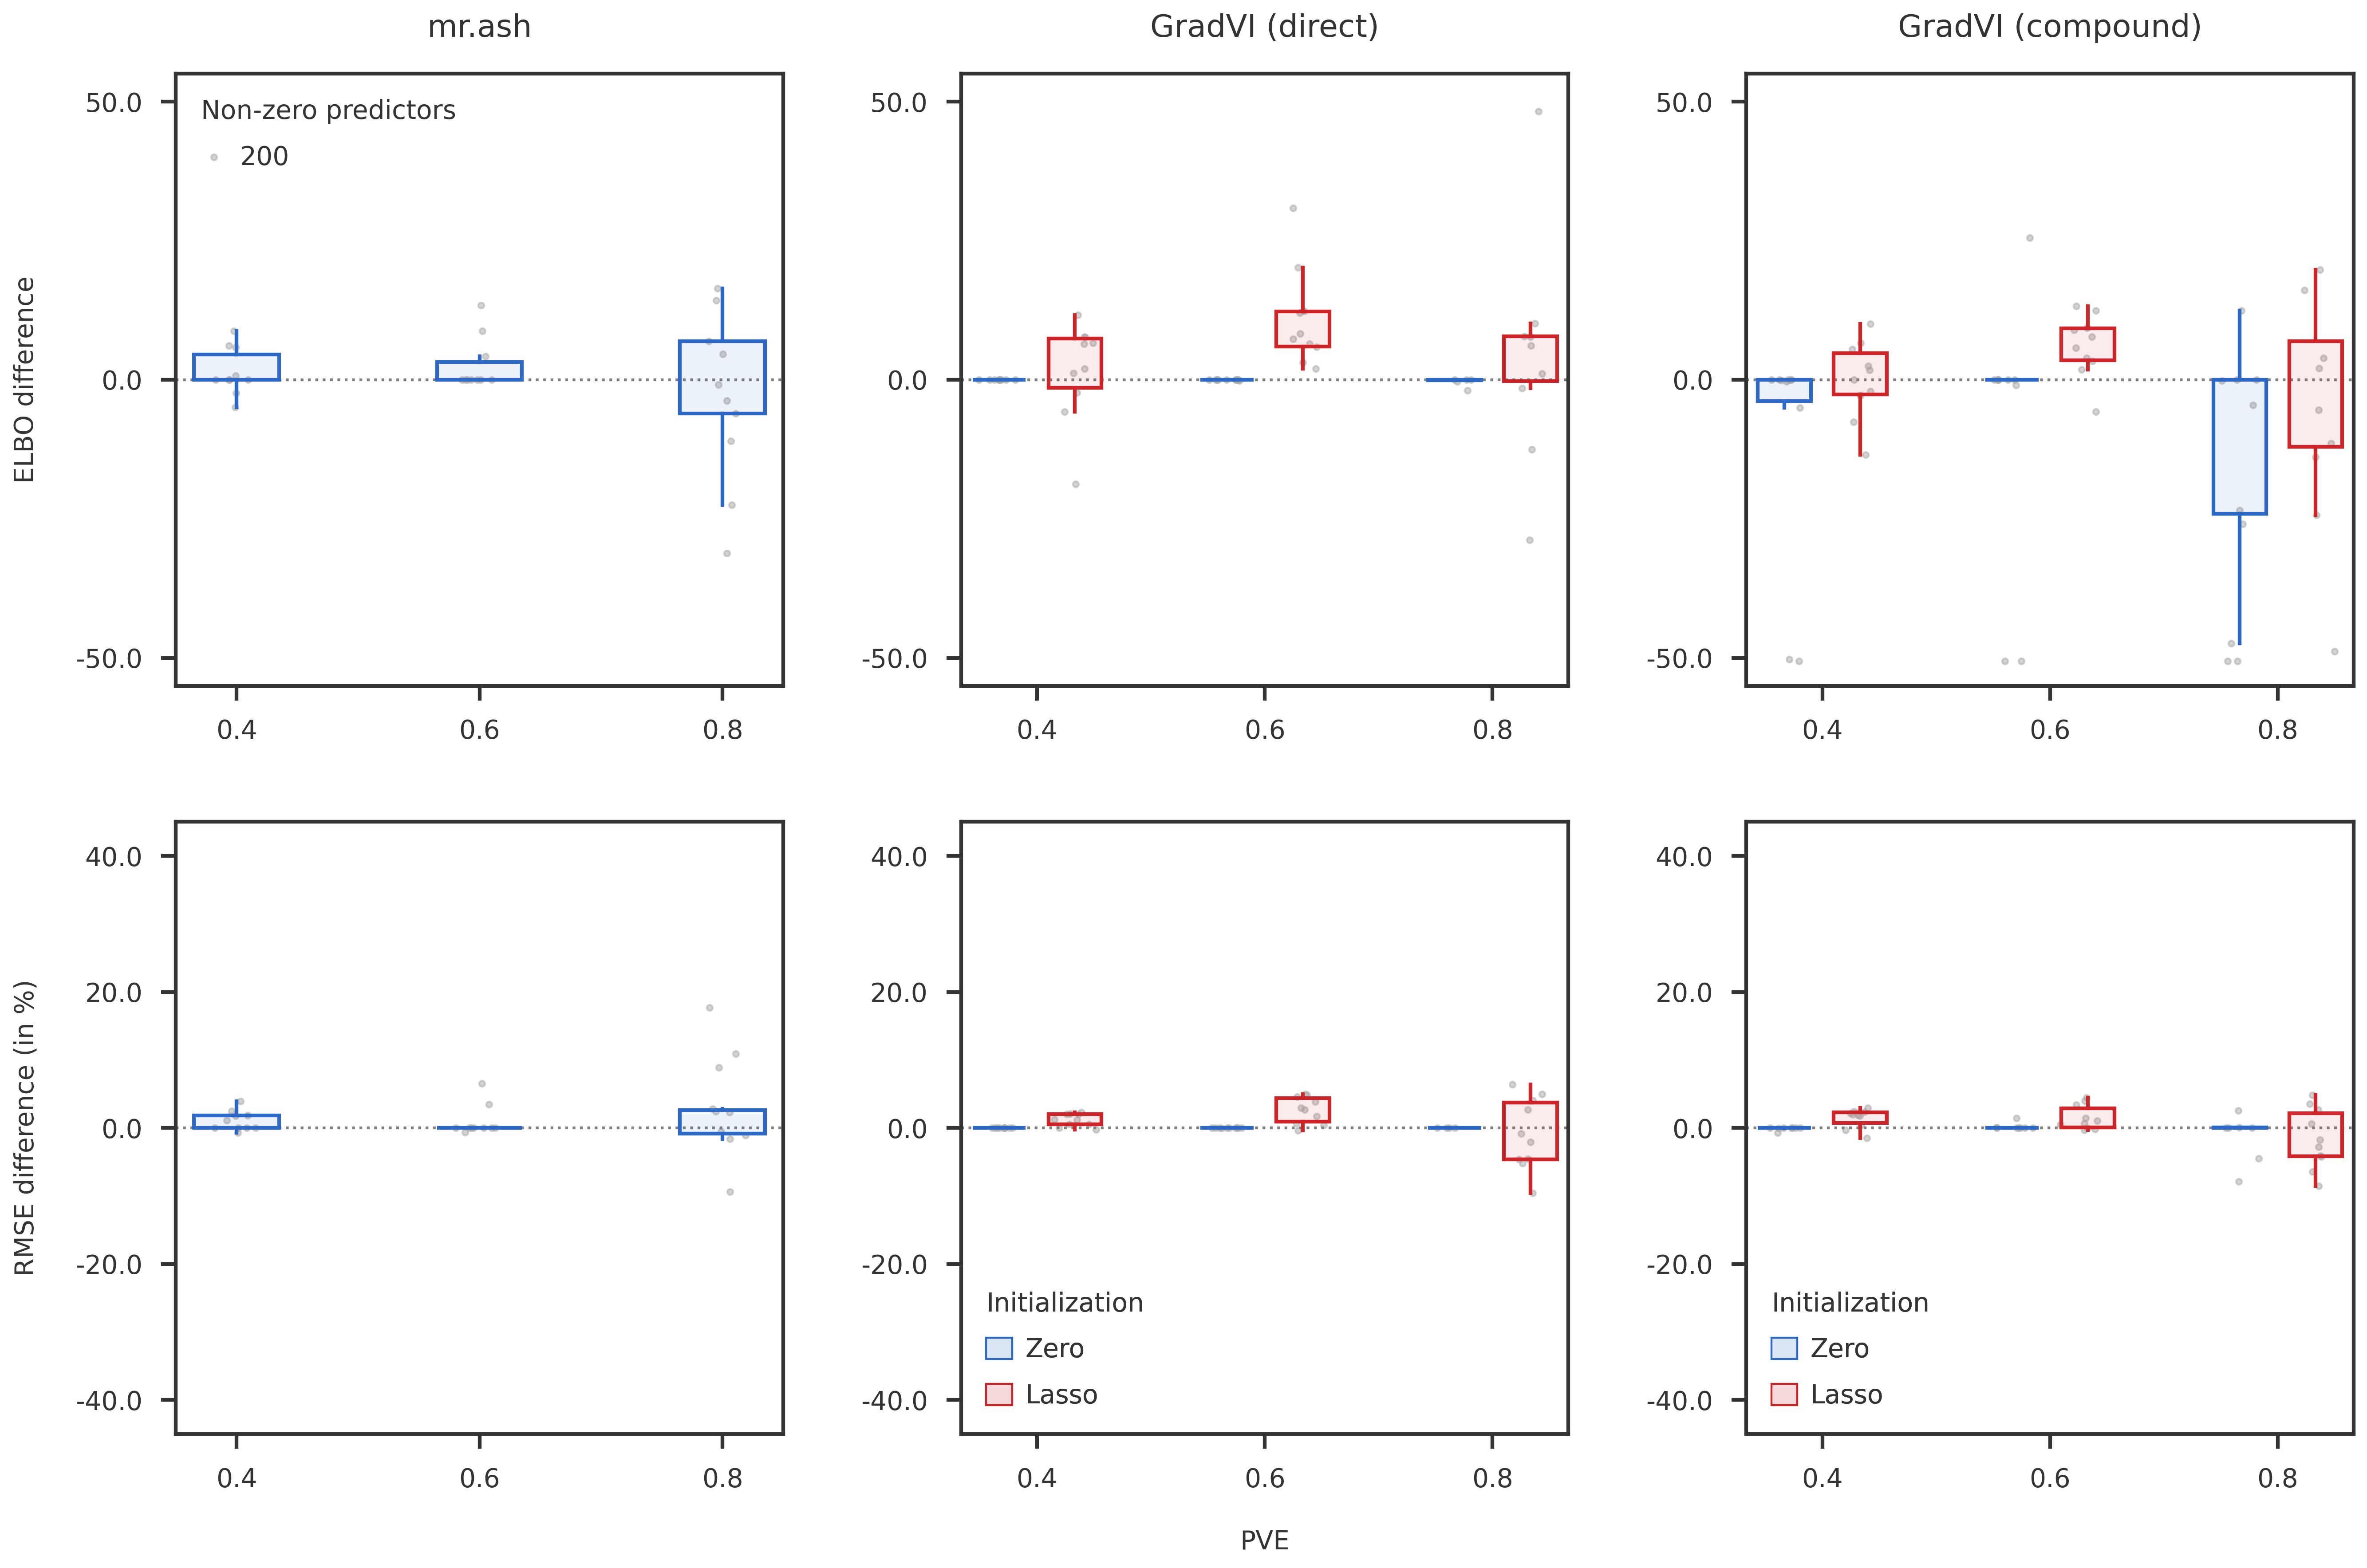

In [33]:
def np_categorize(arr):
    unq = np.unique(arr)
    d1  = {x : i for i, x in enumerate(unq)}
    d2  = {i : x for i, x in enumerate(unq)}
    return np.array([d1[x] for x in arr]), d2

def rand_jitter(arr, d = 0.02):
    stdev = d * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def truncate_jitter(arr, ylim, d = 0.04):
    xnew  = arr.copy()
    if ylim is not None:
        ydev  = d * (ylim[1] - ylim[0])
        ilow  = np.where(xnew < ylim[0] + ydev)[0]
        ihigh = np.where(xnew > ylim[1] - ydev)[0]
        if len(ilow) > 0:
            xnew[ilow]  = ylim[0] + ydev #+ np.abs(np.random.randn(len(ilow))) * ydev
        if len(ihigh) > 0:
            xnew[ihigh] = ylim[1] - ydev
    return xnew

def outlier_index(data):
    q3, q1 = np.percentile(data, [75, 25])
    iqr = q3 - q1
    xmin = q1 - 1.5 * iqr
    xmax = q3 + 1.5 * iqr
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

def outlier_index_normal(data, factor = 0.9):
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    # In ANY normal distribution: IQR = Q3 - Q1 = 0.67448σ - (-0.67448σ) = 1.34896σ
    iqr_sigma = iqr / 1.34896
    median = np.median(data)
    xmin = median - factor * iqr_sigma
    xmax = median + factor * iqr_sigma
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

def get_outlier_index(data, factor = 10.0, keep_outliers = True):
    if keep_outliers:
        iremove = np.array([])
        ikeep   = np.arange(data.shape[0])
    else:
        iremove, ikeep = outlier_index_normal(data, factor = factor)   
    return iremove, ikeep
    

def match_index(idx1, idx2):
    return np.intersect1d(idx1, idx2, assume_unique = True)


def plot_elbo_boxplot(ax, df, reference, targets,
                      colors = None,
                      factr = 1, comparison_mode = 'absolute_diff',
                      keep_outliers = False, use_gradvi_alternate = False,
                      showboxplot = True, showscatter = True, 
                      show_boxlegend = False, show_scatterlegend = False, box_labels = list(),
                      box_legend_title = "Initialization",
                      ylim = None, debug = False):

    ref  = factr * df[reference].to_numpy()
    tgts = [factr * df[target].to_numpy() for target in targets]
    if comparison_mode == 'absolute_diff':
        diffs = [tgt - ref for tgt in tgts]
    elif comparison_mode == 'percentage_diff':
        diffs = [(tgt - ref) * 100 / np.abs(ref) for tgt in tgts]

    sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
    pveidx,  pvevals  = np_categorize(df['simulate.pve'].to_numpy())
    
    # Colors
    if colors is None:
        colors = mpl_stylesheet.banskt_colors()
    
    # The x-axis values and labels
    ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
    if ylim is not None: ax.set_ylim(ylim)
    xvals = list(pvevals.keys())
    xlabels = list(pvevals.values())
    
    # Box plot for each PVE
    if showboxplot:
        nbox = len(targets)
        for i, target in enumerate(targets):
            boxcolor = colors[i]
            boxface = f'#{boxcolor[1:]}16' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
            medianprops = dict(linewidth=0, color = boxcolor)
            whiskerprops = dict(linewidth=2, color = boxcolor)
            boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
            flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)
            
            # plotting data
            diff = diffs[i]
            iremove, ikeep = get_outlier_index(diff, factor = 5.0, keep_outliers = keep_outliers)
            positions = np.array(range(len(xvals))) * (nbox + 1) + i
            ylist = [diff[match_index(np.where(pveidx == i)[0], ikeep)] for i in xvals]
            
            # print outliers
            if debug:
                print (f"Number of outliers removed : {iremove[0].shape[0]}")
                for j in iremove[0]:
                    print(f"Index {j},\tPVE={pvevals[pveidx[j]]}, s={sfixvals[sfixidx[j]]}\t diff = {diff[j]:g}")
            # ---------------
            
            ax.boxplot(ylist, positions = positions,
                       showcaps = False, showfliers = False,
                       widths = 0.7, patch_artist = True, notch = False,
                       flierprops = flierprops, boxprops = boxprops,
                       medianprops = medianprops, whiskerprops = whiskerprops)
                
            
        label_positions = np.array(range(len(xvals))) * (nbox + 1) + (nbox - 1) / 2.0
        ax.set_xticks(label_positions)
        ax.set_xticklabels(xlabels)
        #mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear', fmt = '{:.1f}')
        mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear')
        
        if show_boxlegend:
            #mhandles, mlabels = ax.get_legend_handles_labels()
            mhandles = list()
            mlabels  = list()
            for i, target in enumerate(targets):
                boxcolor = colors[i]
                boxface = f'#{boxcolor[1:]}16'
                mhandles.append(mpatches.Patch(facecolor = boxface, edgecolor = boxcolor))
                mlabels.append(box_labels[i])
            leg1 = ax.legend(handles = mhandles, labels = mlabels, title = box_legend_title,
                             loc = 'lower left', bbox_to_anchor = (0.02, 0.02), ncol = 1)
            leg1._legend_box.align = "left"
            ax.add_artist(leg1)

    # Scatter plot with jitter, showing sfix
    if showscatter:
        mcolors  = mpl_stylesheet.kelly_colors()
        mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
        xpve = rand_jitter(pveidx)
        
        nbox = len(targets)
        for i, target in enumerate(targets):
            diff = diffs[i]
            iremove, ikeep = get_outlier_index(diff, factor = 10.0, keep_outliers = keep_outliers)
            xpve = rand_jitter(pveidx * (nbox + 1) + i)
            
            diff_trunc = truncate_jitter(diff, ylim)
            for sidx, sfix in sfixvals.items():
                marker  = 'o' #mmarkers[sidx]
                color   = 'darkgray' #mcolors[sidx]
                _idx    = np.where(sfixidx == sidx)[0]
                _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
                ax.scatter(xpve[_ikeep], diff_trunc[_ikeep], marker = marker, c = color,
                           alpha = 0.5, s = 10, linewidth = 1, label = f"{sfix}")
        
        # legend for number of causal predictors
        if show_scatterlegend:
            mhandles, mlabels = ax.get_legend_handles_labels()
            by_label = dict(zip(mlabels, mhandles))
            leg2 = ax.legend(handles = by_label.values(), labels = by_label.keys(), title = "Non-zero predictors",
                             loc = 'upper left', bbox_to_anchor = (0.02, 0.98), ncol = 2)
            leg2._legend_box.align = "left"


fig = plt.figure(figsize = (18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

#elbo_ylim = None #[-2.1, 1.2]
elbo_ylim = [-55, 55]

#ax1.scatter(rand_jitter(pveidx), diff, alpha = 0.5)
plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash_lasso_init", ["mr_ash"], show_scatterlegend = True,
                  comparison_mode = 'absolute_diff', factr = -1,
                  keep_outliers = False, ylim = elbo_ylim)
plot_elbo_boxplot(ax2, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_direct", "gradvi_direct_lasso_init"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  keep_outliers = False, ylim = elbo_ylim)
plot_elbo_boxplot(ax3, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_compound_lasso_init"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  keep_outliers = False, ylim = elbo_ylim)

mse_ylim = [-45, 45]
#mse_ylim = None
plot_elbo_boxplot(ax4, msedf_filtered,
                  "mr_ash_lasso_init", ["mr_ash"],
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = mse_ylim)
plot_elbo_boxplot(ax5, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_direct", "gradvi_direct_lasso_init"], 
                  show_boxlegend = True, box_labels = ["Zero", "Lasso"], 
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = mse_ylim)
plot_elbo_boxplot(ax6, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_compound_lasso_init"], 
                  show_boxlegend = True, box_labels = ["Zero", "Lasso"],
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = mse_ylim)


ax1.set_ylabel(r"ELBO difference")
ax1.set_title("mr.ash", pad = 20)
ax2.set_title("GradVI (direct)", pad = 20)
ax3.set_title("GradVI (compound)", pad = 20)
ax4.set_ylabel(r"RMSE difference (in %)")
ax5.set_xlabel("PVE")

plt.tight_layout(w_pad = 3.0, h_pad = 3.0)
#utils.saveplot(fig, plotprefix)
plt.show()

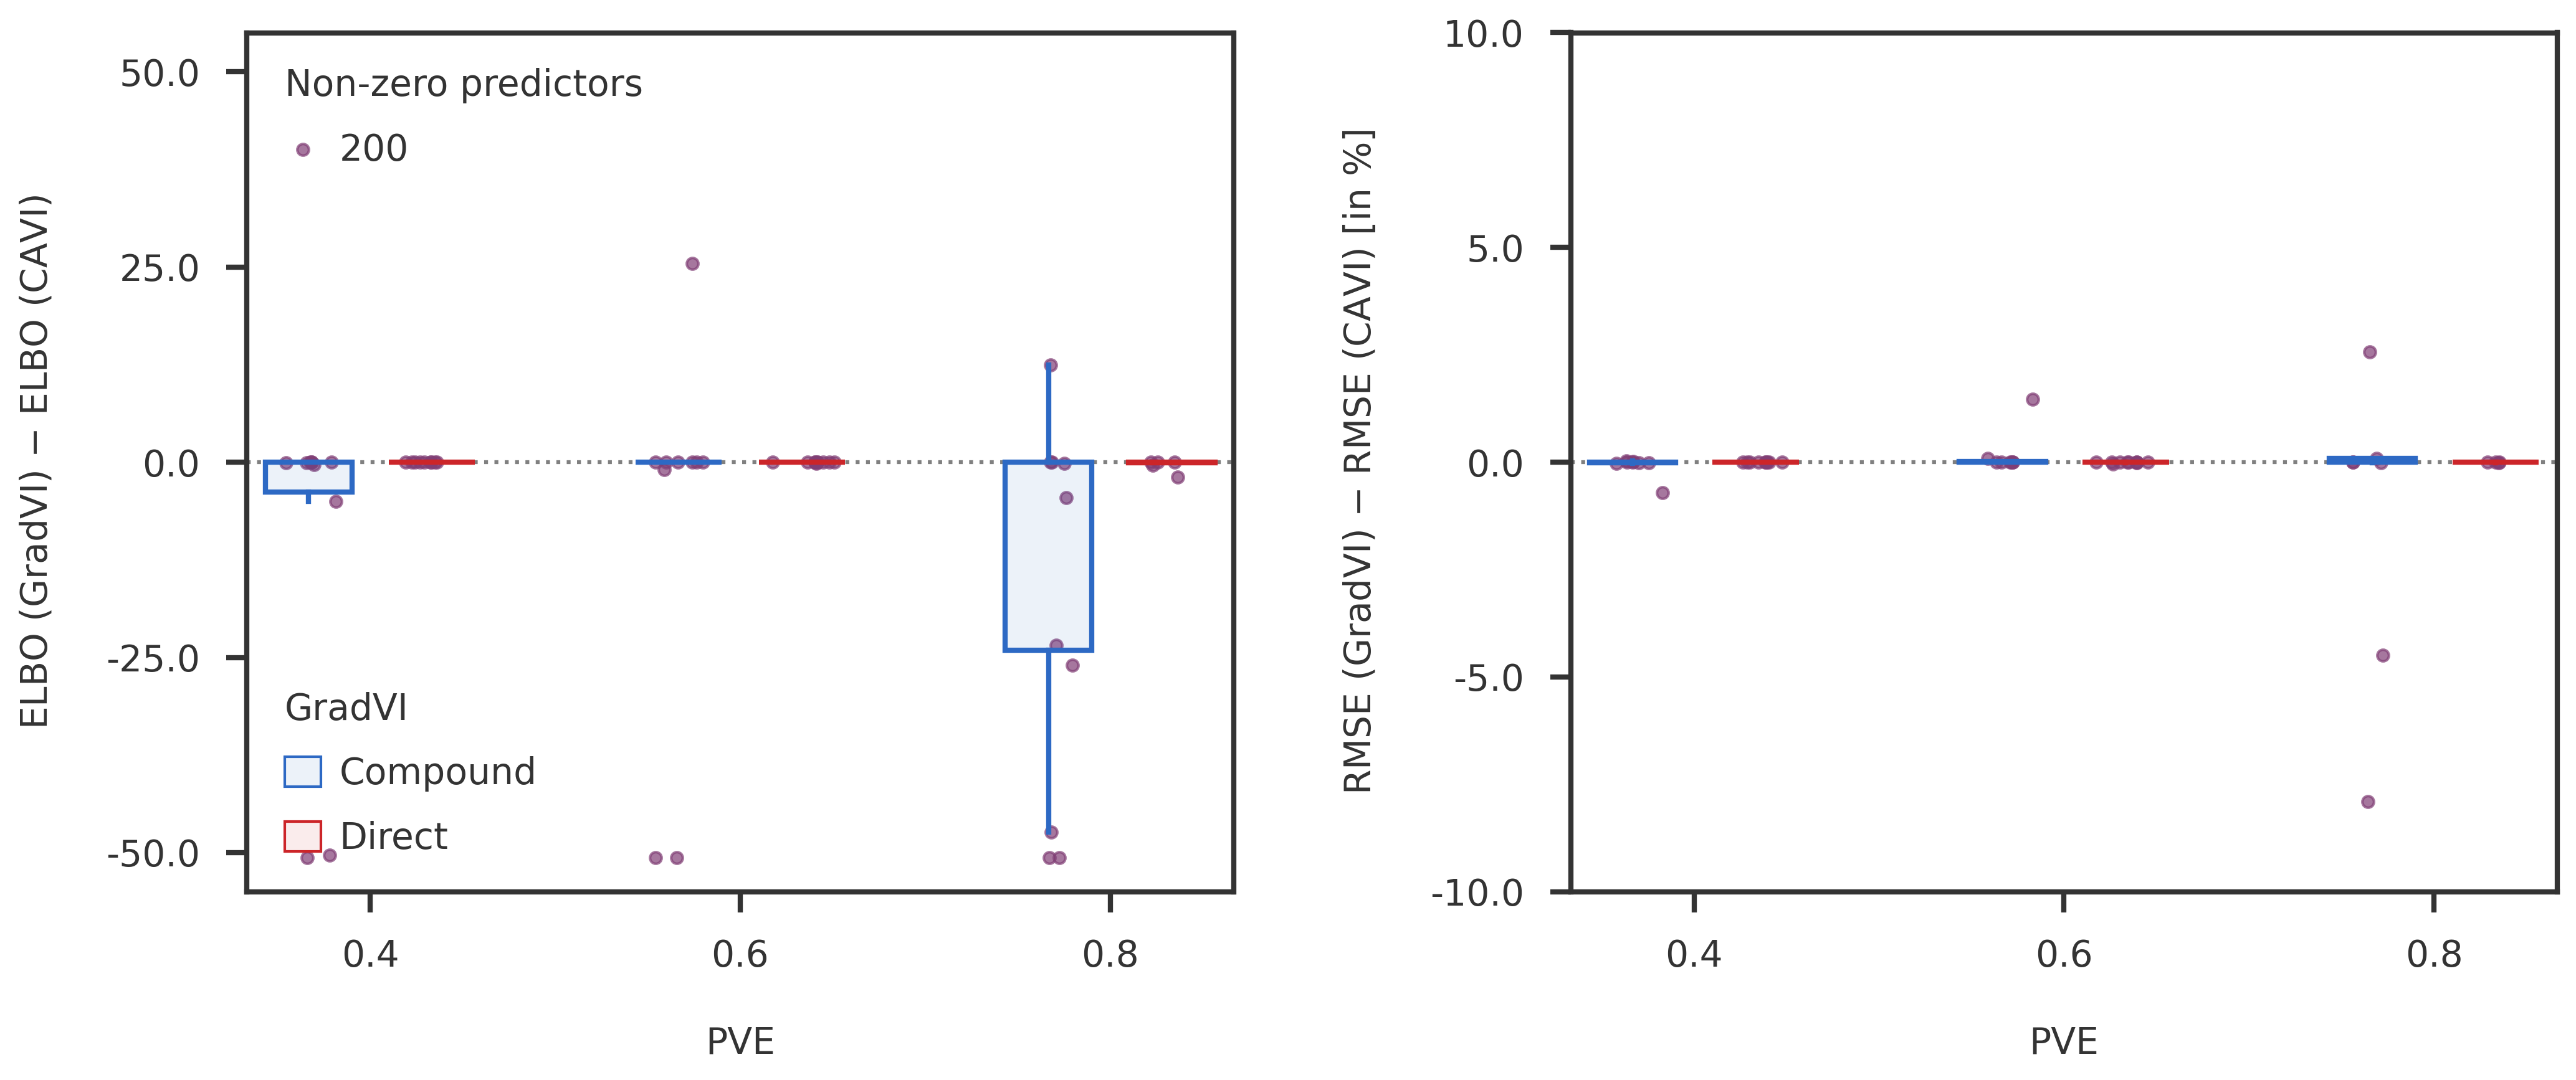

In [31]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_direct"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  show_scatterlegend = True,
                  show_boxlegend = True, box_labels = ["Compound", "Direct"], 
                  box_legend_title = "GradVI",
                  keep_outliers = False, ylim = elbo_ylim)

plot_elbo_boxplot(ax2, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_direct"], 
                  show_boxlegend = False, 
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = [-10, 10])

ax1.set_ylabel(r"ELBO (GradVI) $-$ ELBO (CAVI)")
ax2.set_ylabel(r"RMSE (GradVI) $-$ RMSE (CAVI) [in %]")
ax1.set_xlabel("PVE")
ax2.set_xlabel("PVE")

mpl_utils.set_yticks(ax1, kmin = 4, kmax = 10)
mpl_utils.set_yticks(ax2, kmin = 4, kmax = 10)

plt.tight_layout(w_pad = 3.0)
#utils.saveplot(fig, "gradvi_linreg_corr_converge_to_cavi")
plt.show()

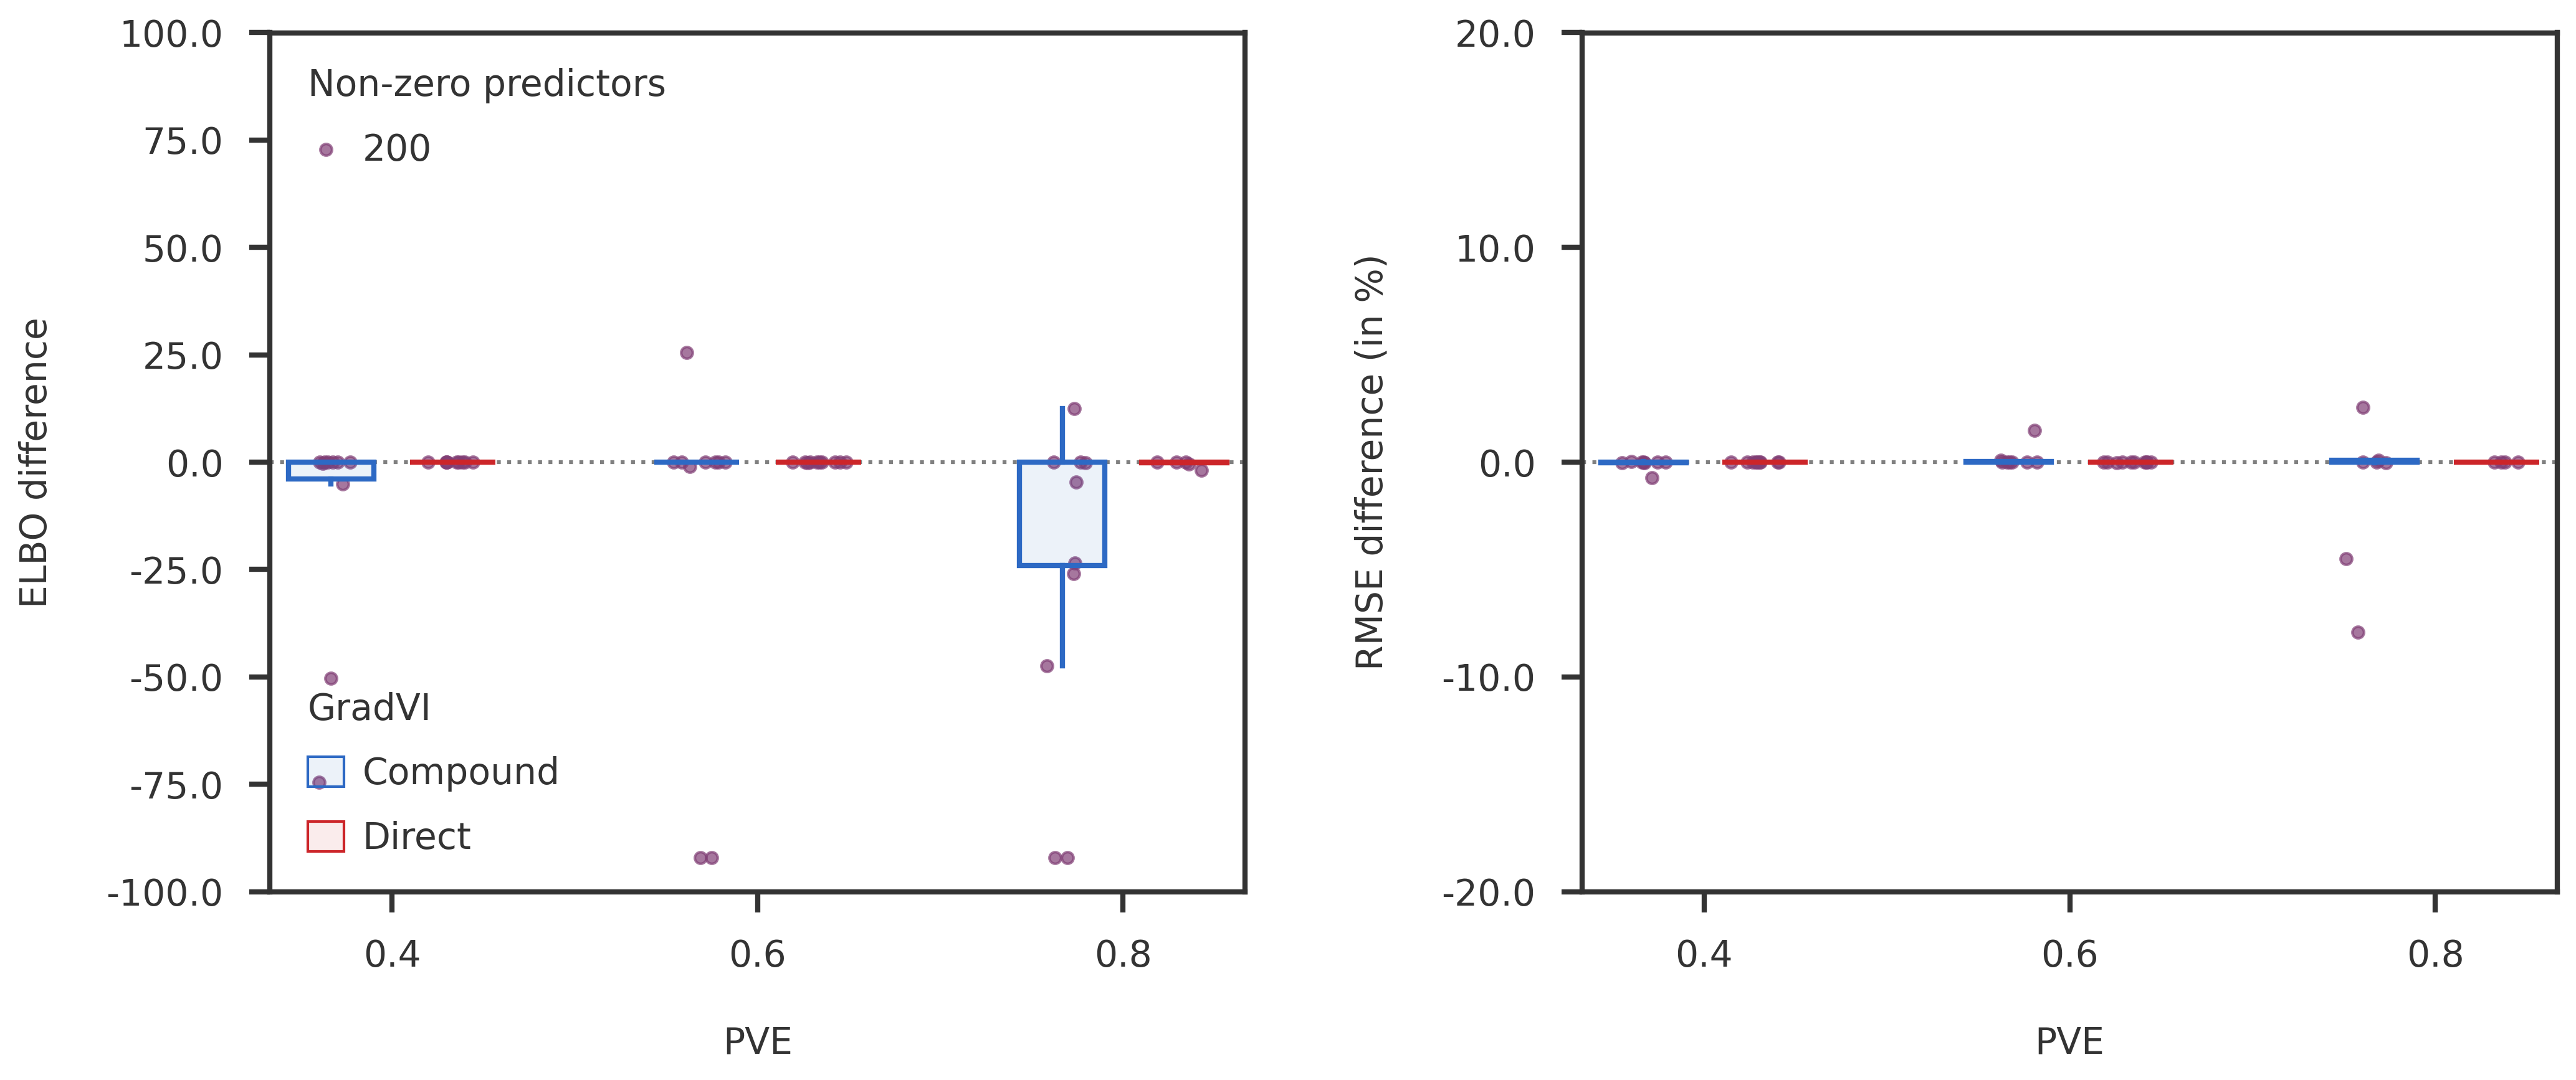

In [28]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_direct"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  show_scatterlegend = True,
                  show_boxlegend = True, box_labels = ["Compound", "Direct"], 
                  box_legend_title = "GradVI",
                  keep_outliers = False, ylim = [-100, 100])

plot_elbo_boxplot(ax2, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_direct"], 
                  show_boxlegend = False, 
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = [-20, 20])

ax1.set_ylabel(r"ELBO difference")
ax2.set_ylabel(r"RMSE difference (in %)")
ax1.set_xlabel("PVE")
ax2.set_xlabel("PVE")

mpl_utils.set_yticks(ax1, kmin = 4, kmax = 10)
mpl_utils.set_yticks(ax2, kmin = 4, kmax = 10)

plt.tight_layout(w_pad = 3.0)
#utils.saveplot(fig, "gradvi_linreg_corr_converge_to_cavi_no_init")
plt.show()

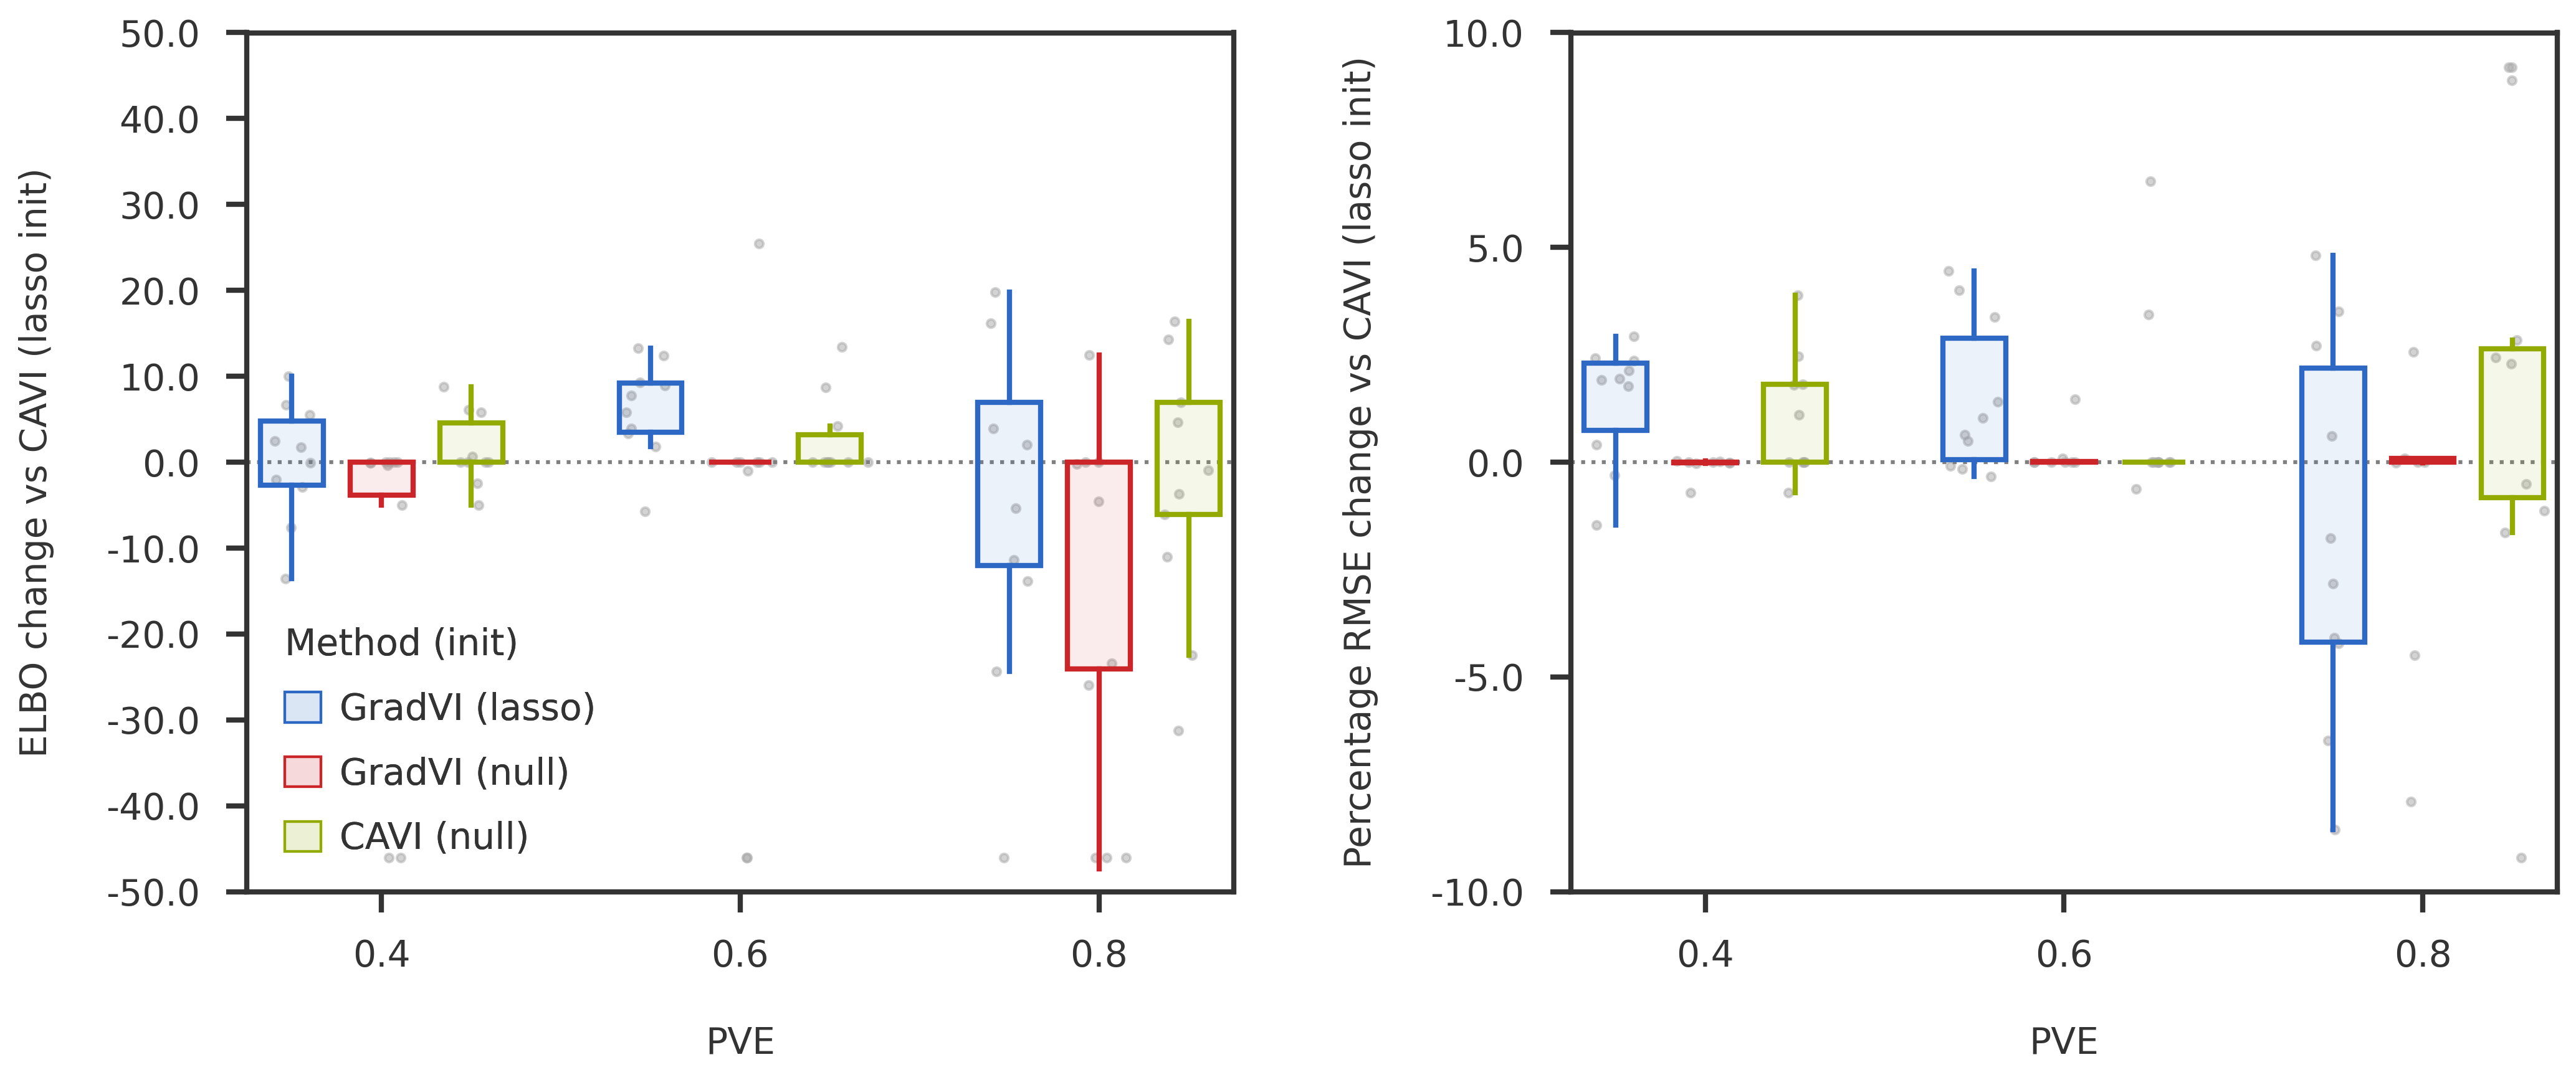

In [37]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_compound_lasso_init", "gradvi_compound", "mr_ash"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  show_scatterlegend = False,
                  show_boxlegend = True, box_labels = ["GradVI (lasso)", "GradVI (null)", "CAVI (null)"], 
                  box_legend_title = "Method (init)",
                  keep_outliers = False, ylim = [-50, 50])

plot_elbo_boxplot(ax2, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_compound_lasso_init", "gradvi_compound", "mr_ash"], 
                  show_boxlegend = False, 
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = [-10, 10])

ax1.set_ylabel(r"ELBO change vs CAVI (lasso init)")
ax2.set_ylabel(r"Percentage RMSE change vs CAVI (lasso init)")
ax1.set_xlabel("PVE")
ax2.set_xlabel("PVE")

mpl_utils.set_yticks(ax1, kmin = 4, kmax = 10)
mpl_utils.set_yticks(ax2, kmin = 4, kmax = 10)

plt.tight_layout(w_pad = 3.0)
#utils.saveplot(fig, "linreg_corr_compare_inits_gradvi_cavi")
plt.show()

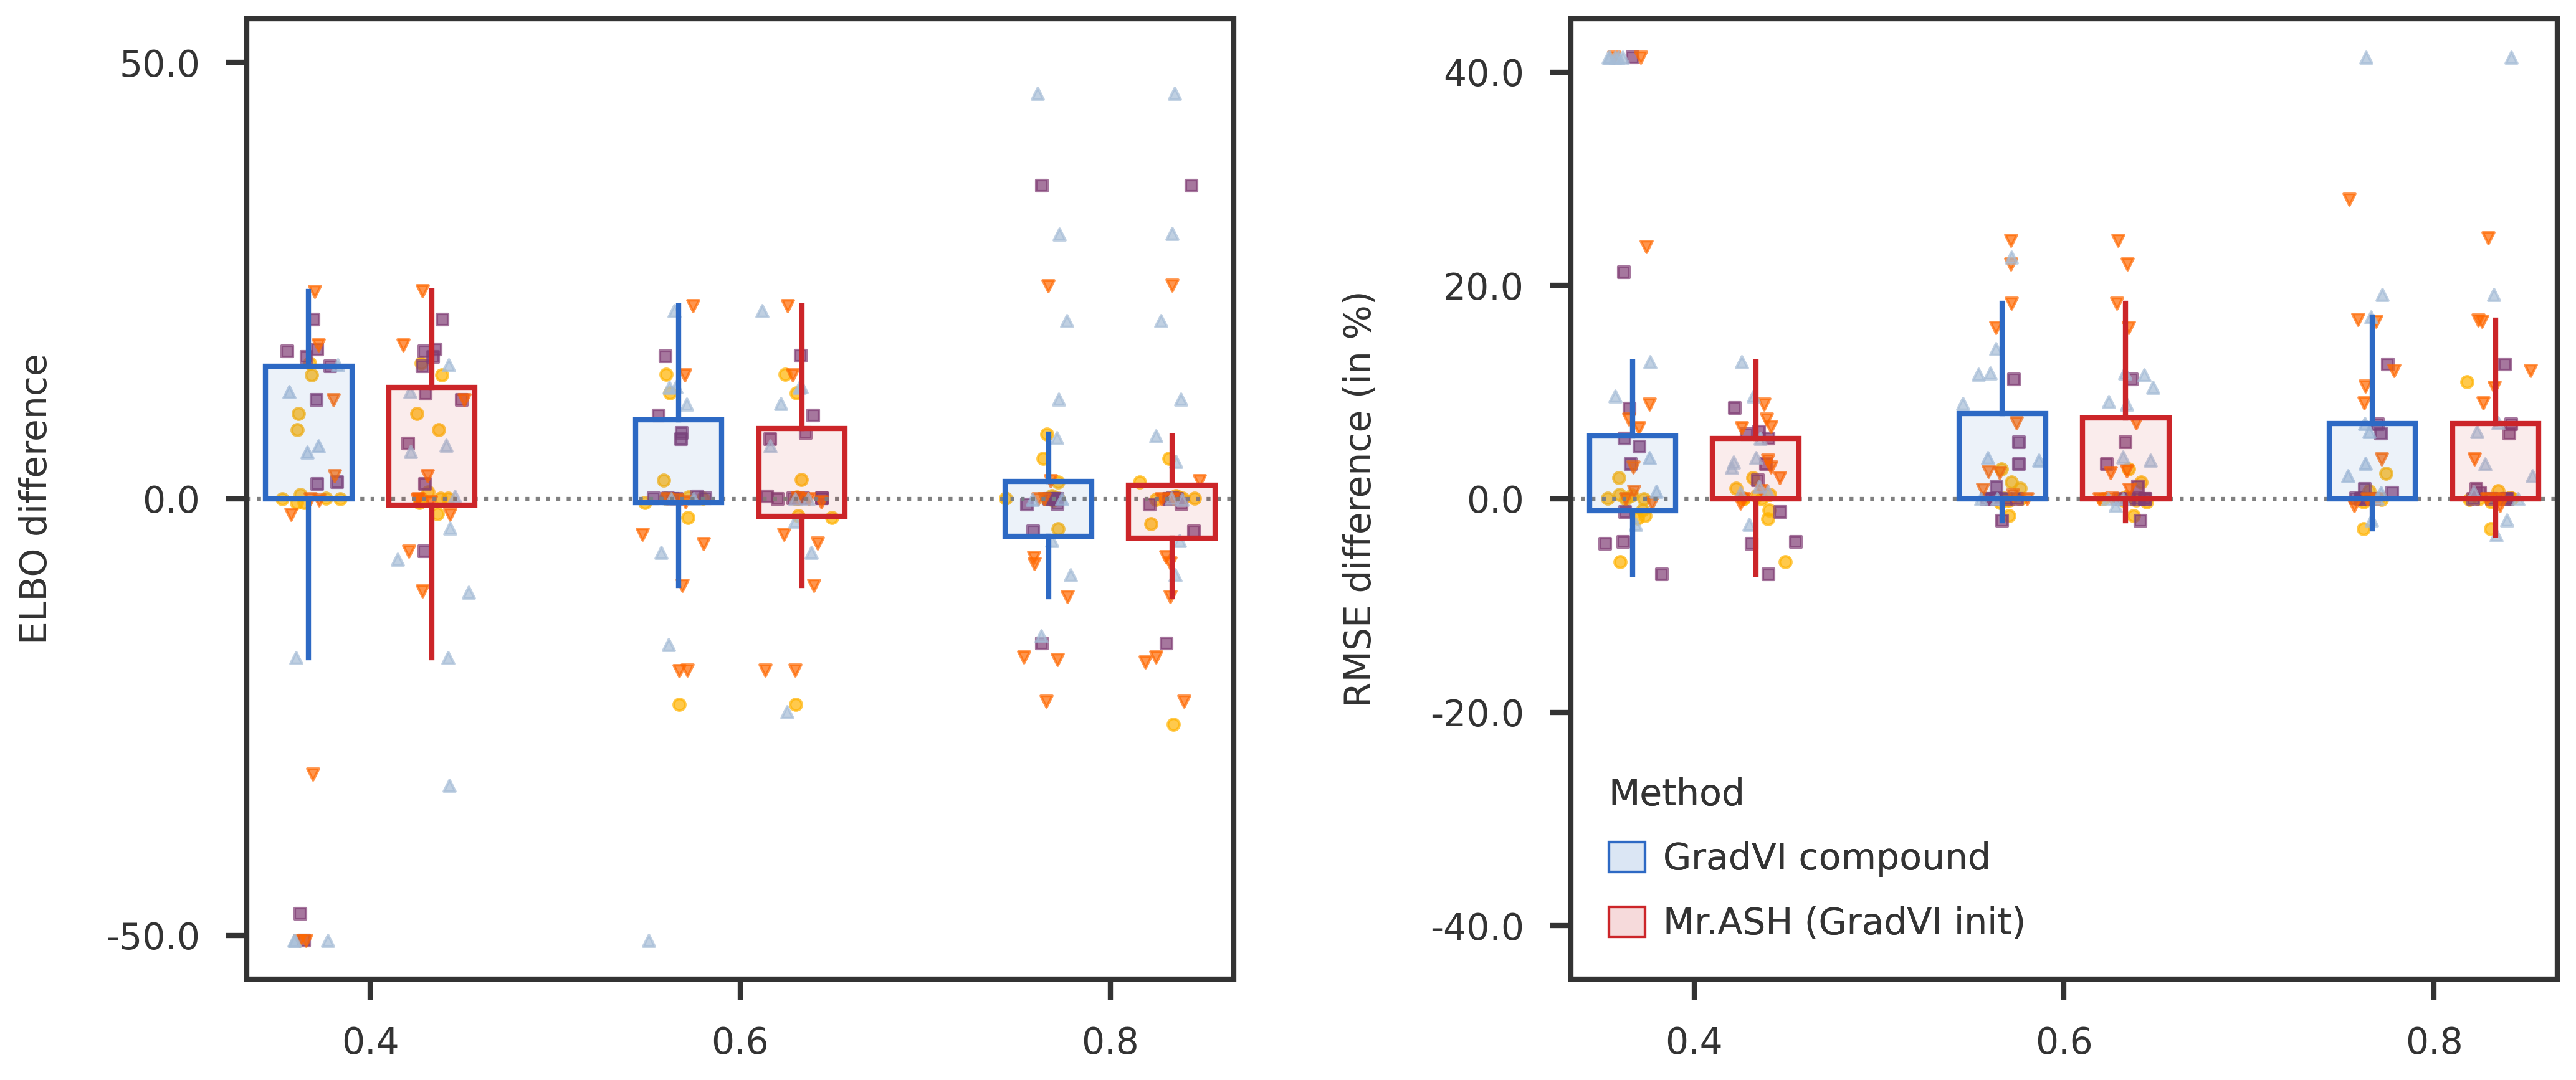

In [15]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_compound_mrash"],
                  show_scatterlegend = False,
                  comparison_mode = 'absolute_diff', factr = -1,
                  keep_outliers = False, ylim = elbo_ylim)

plot_elbo_boxplot(ax2, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_compound_mrash"], 
                  show_boxlegend = True, box_labels = ["GradVI compound", "Mr.ASH (GradVI init)"],
                  box_legend_title = "Method",
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = mse_ylim)

ax1.set_ylabel(r"ELBO difference")
ax2.set_ylabel(r"RMSE difference (in %)")

plt.tight_layout(w_pad = 3.0, h_pad = 3.0)
#utils.saveplot(fig, "mrash_elbo_update_after_gradvi_compound")
plt.show()

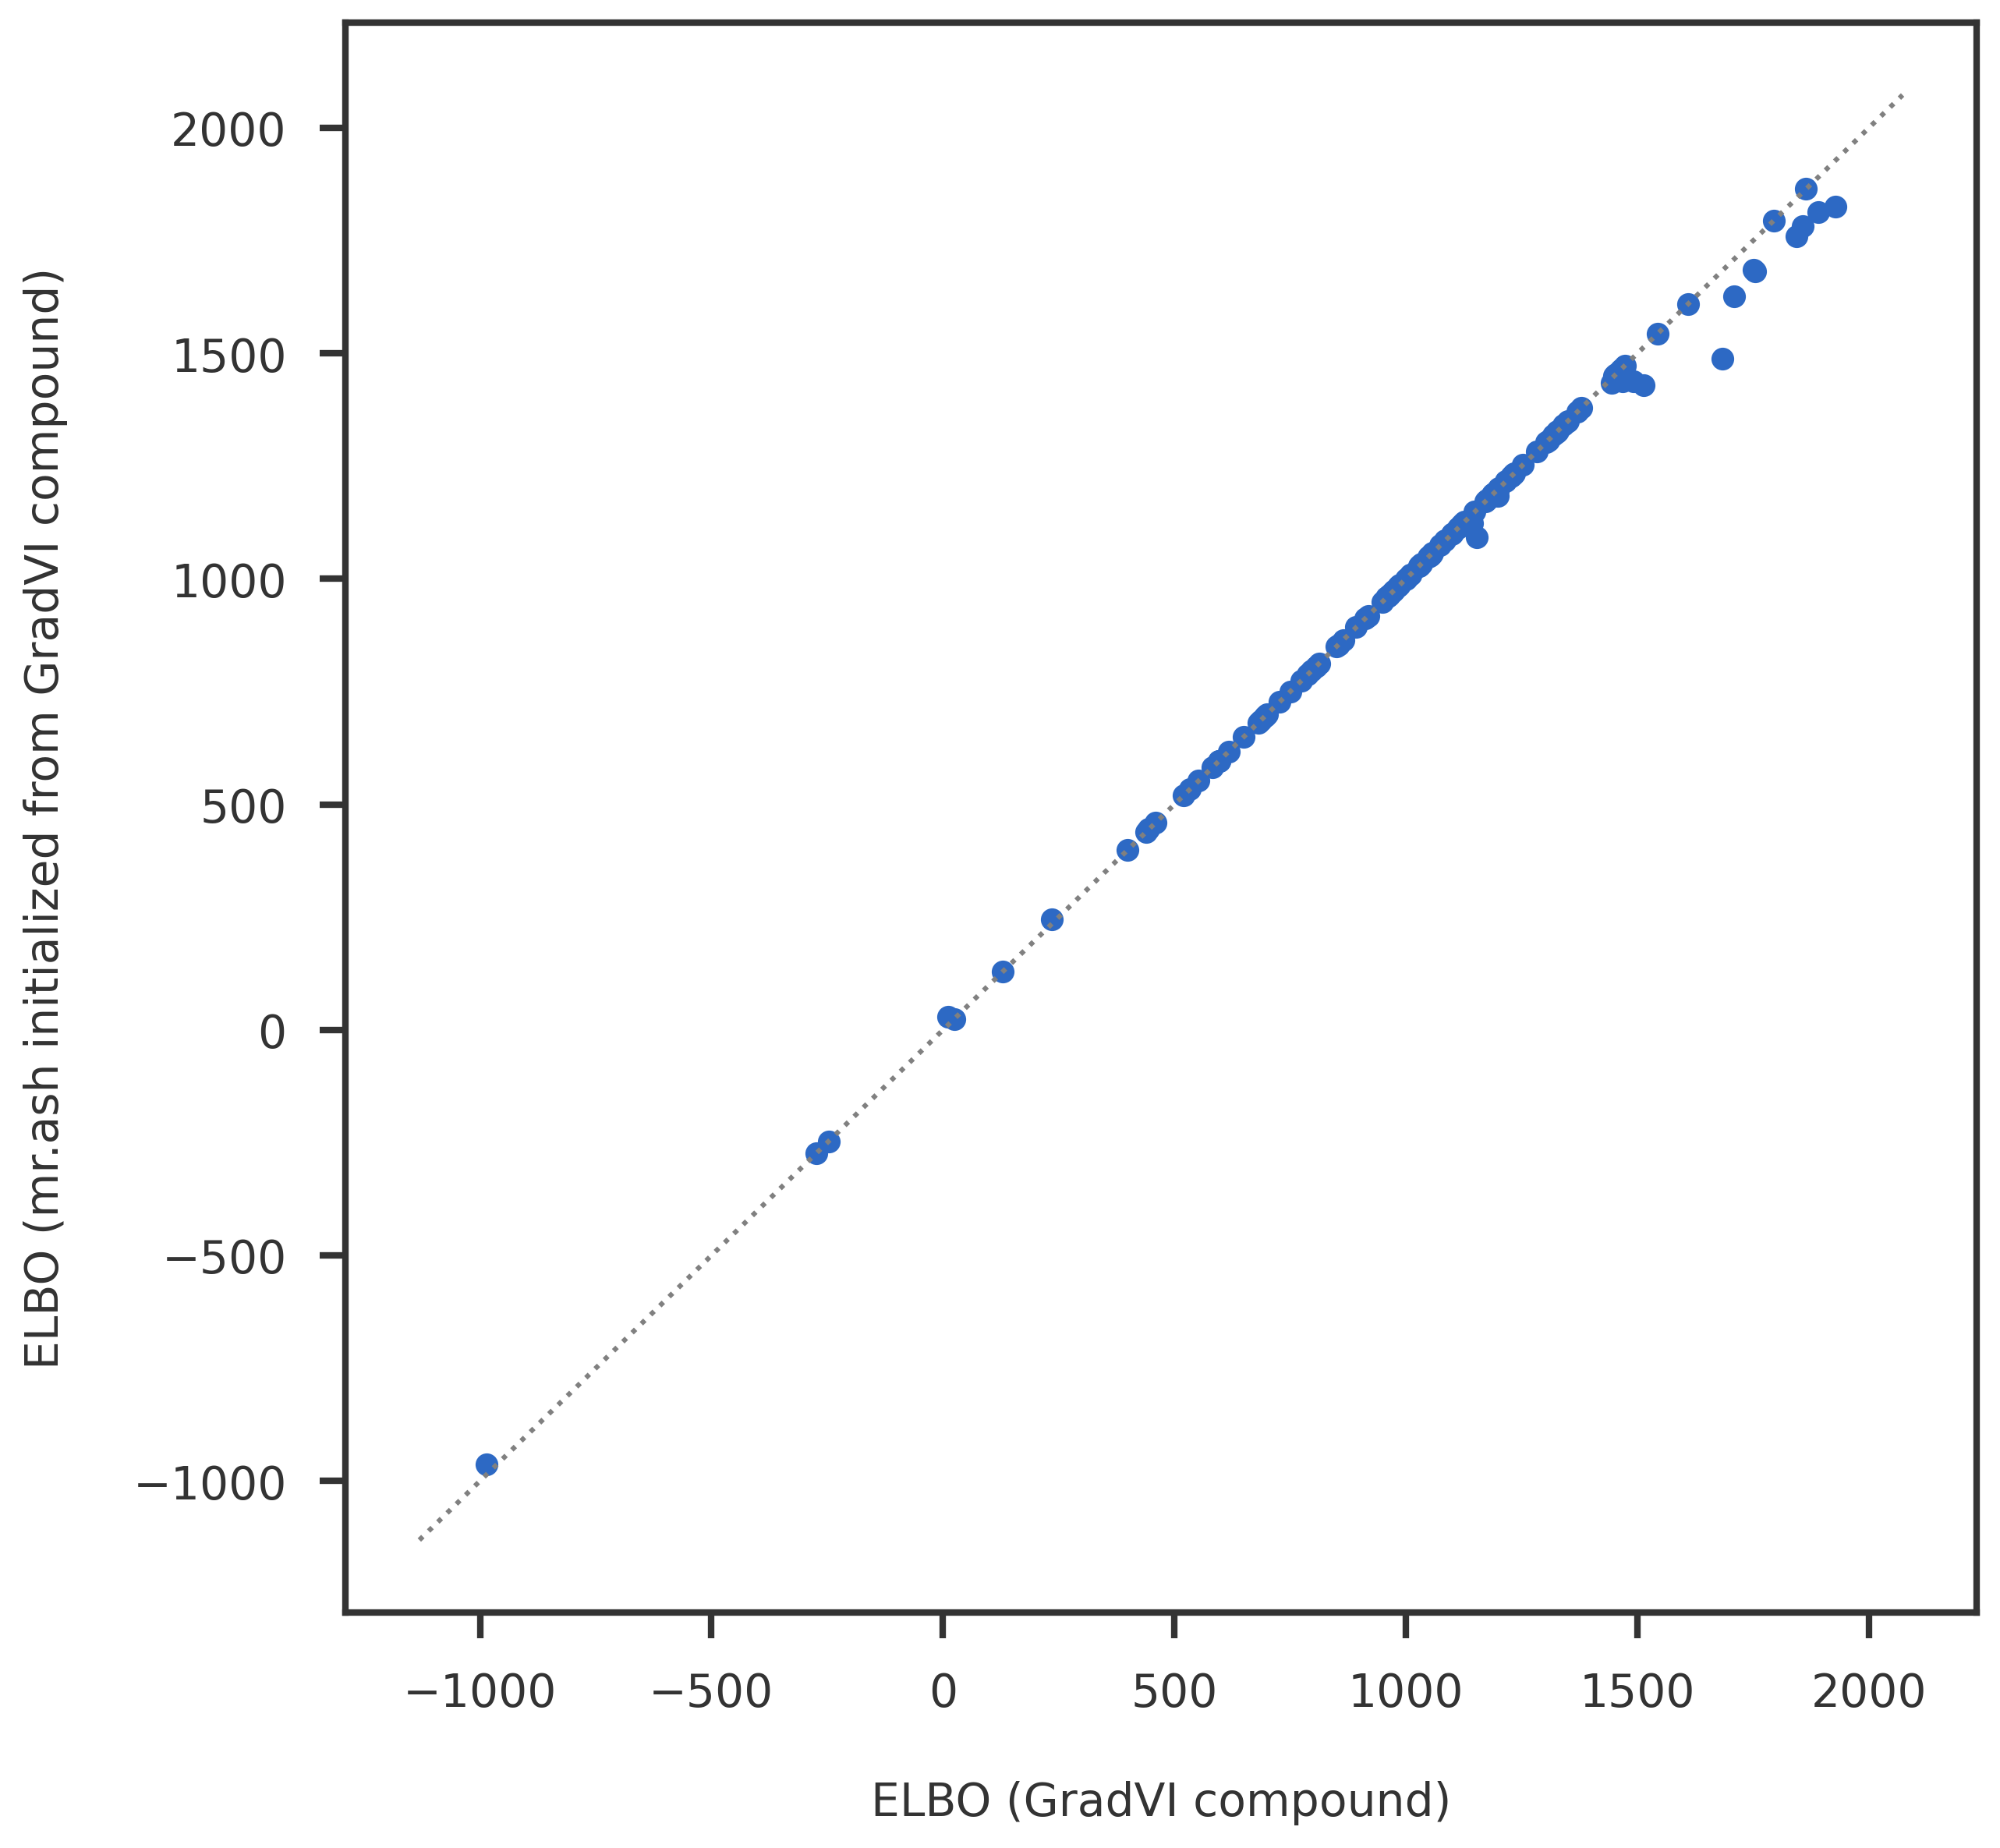

In [22]:
gradvi_elbos = elbodf_filtered['gradvi_compound'].to_numpy()
mrash_elbos  = elbodf_filtered['gradvi_compound_mrash'].to_numpy()

fig = plt.figure(figsize = (9, 9))
ax1 = fig.add_subplot(111)
ax1.scatter(gradvi_elbos, mrash_elbos)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("ELBO (GradVI compound)")
ax1.set_ylabel("ELBO (mr.ash initialized from GradVI compound)")
#utils.saveplot(fig, "mrash_elbo_update_after_gradvi_compound")
plt.show()

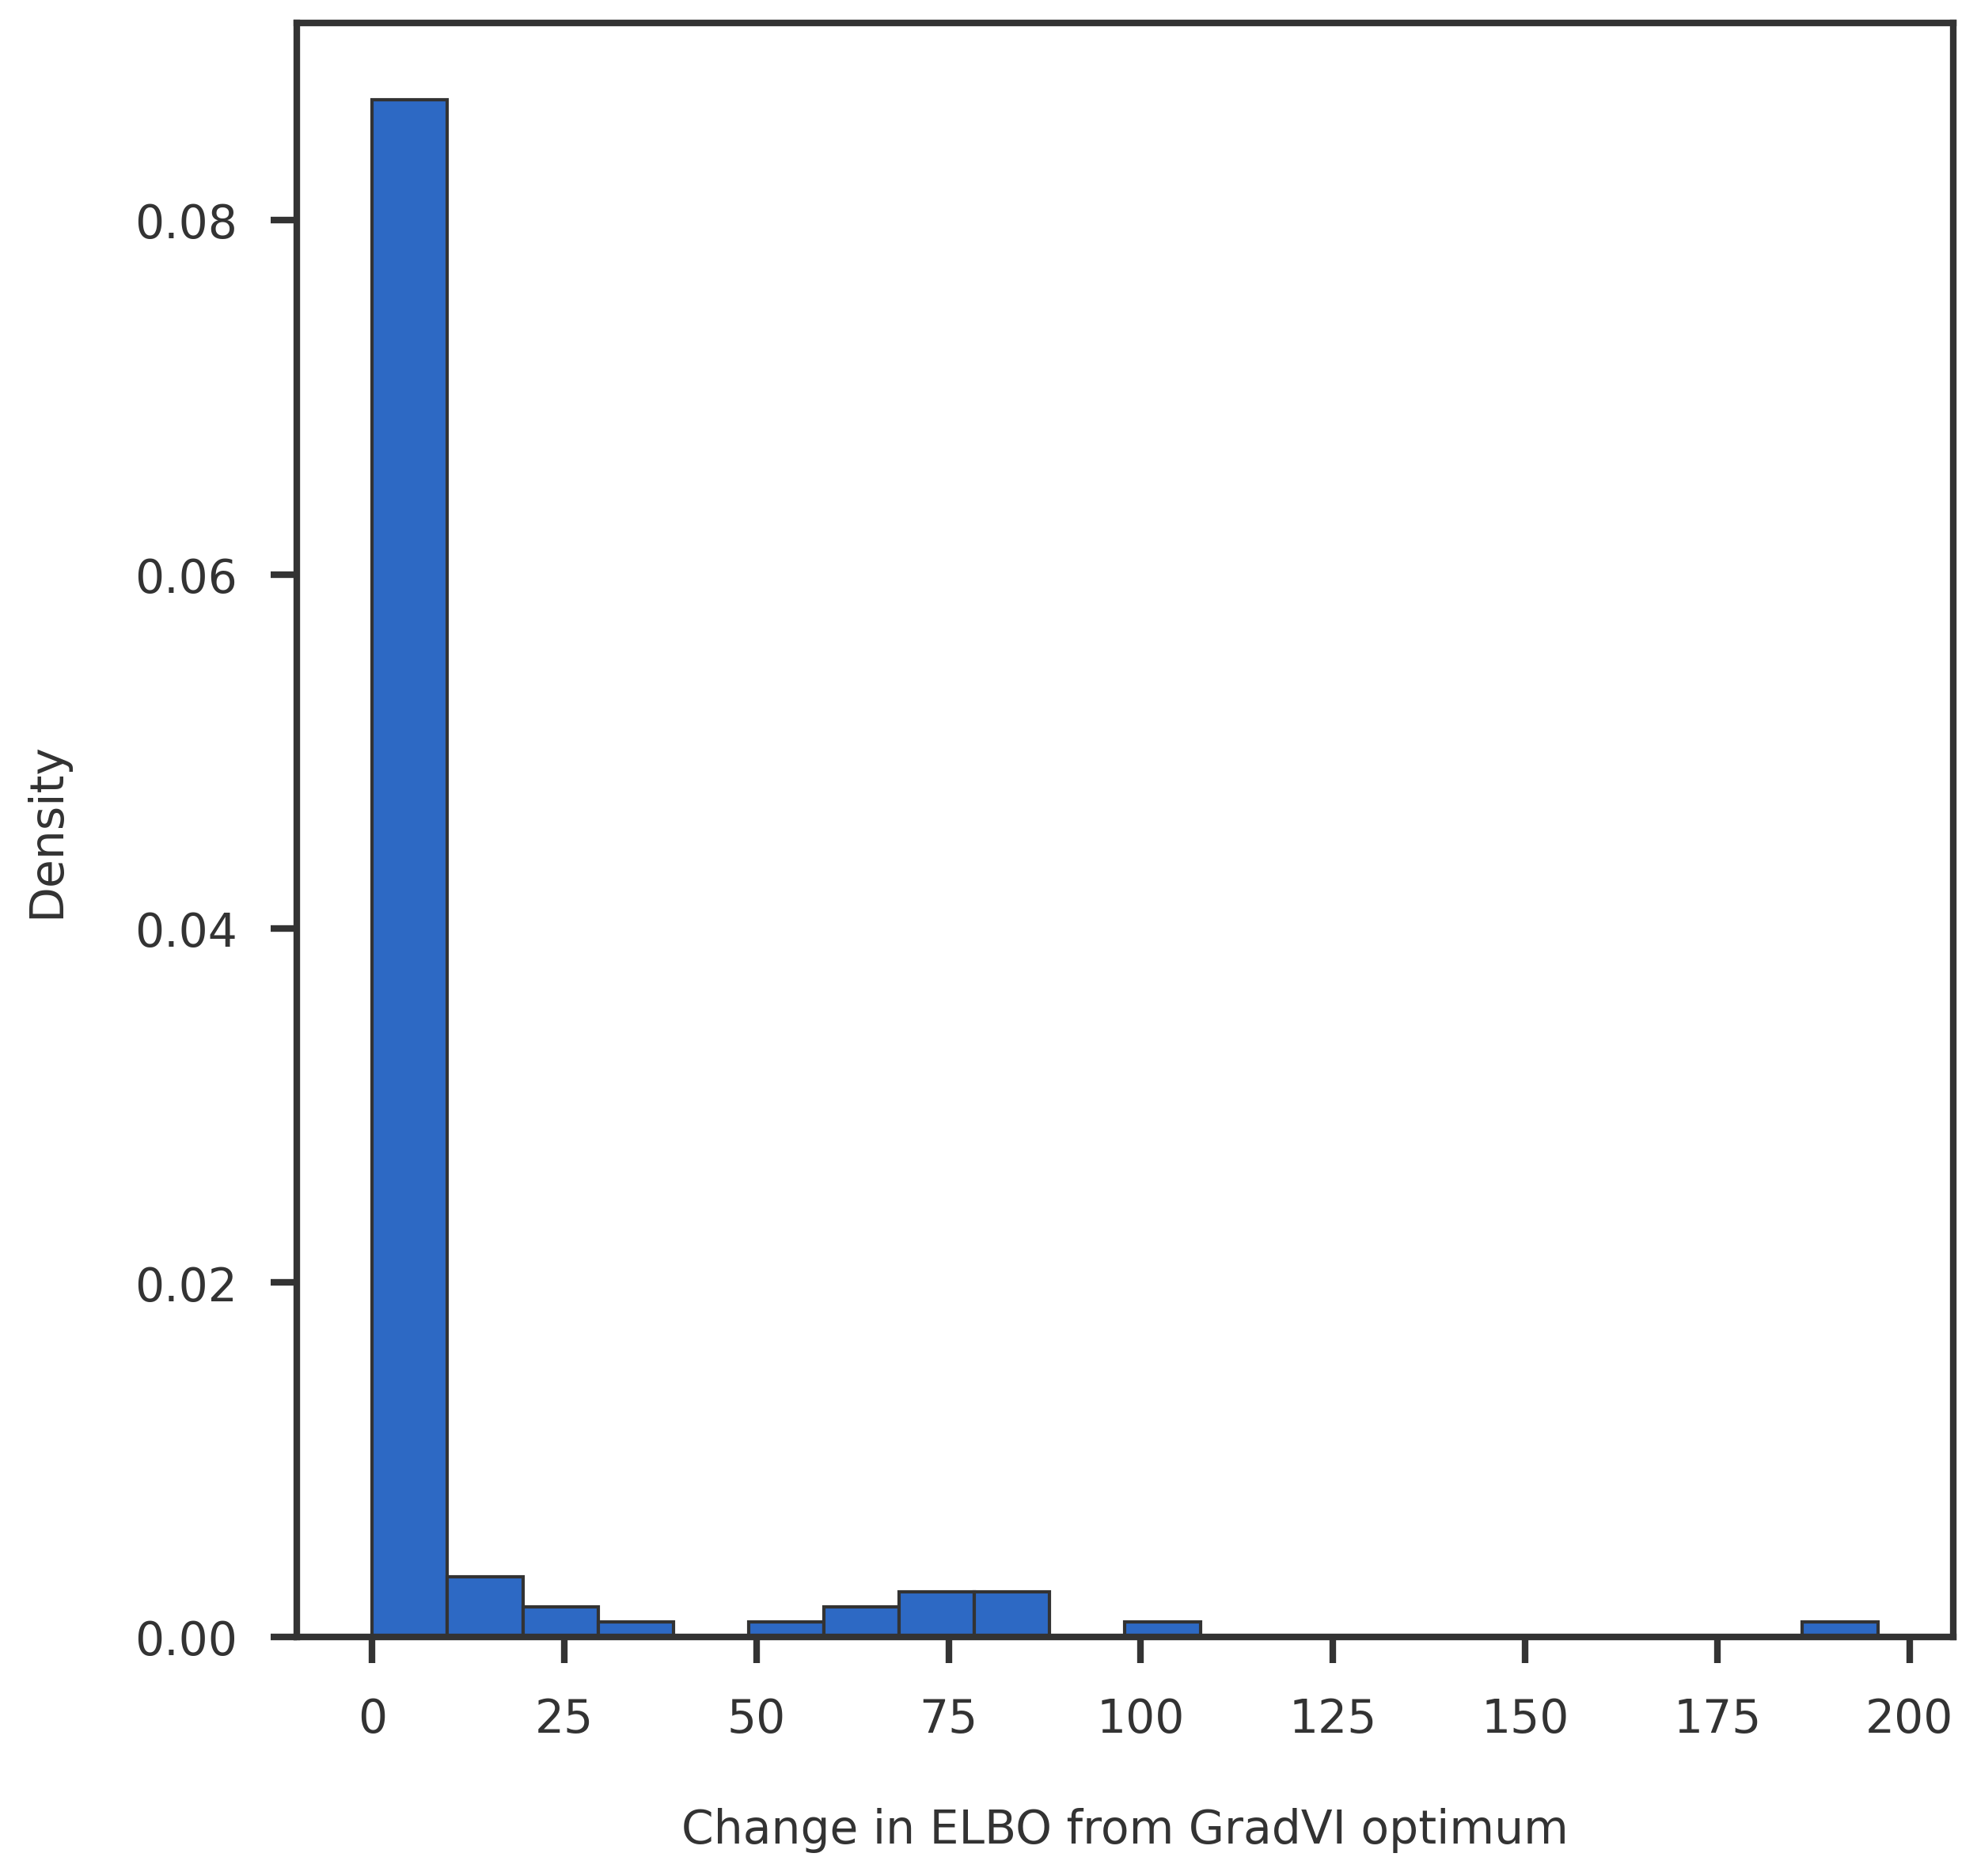

In [29]:
elbo_diffs = mrash_elbos - gradvi_elbos

fig = plt.figure(figsize = (9, 9))
ax1 = fig.add_subplot(111)
ax1.hist(abs(elbo_diffs), density=True)
#mpl_utils.plot_diag(ax1)
ax1.set_xlabel("Change in ELBO from GradVI optimum")
ax1.set_ylabel("Density")
utils.saveplot(fig, "mrash_elbo_update_after_gradvi_compound")
plt.show()

In [ ]:
def plot_elbo_boxplot(ax, df, reference, targets,
                      colors = None,
                      factr = 1, comparison_mode = 'absolute_diff',
                      keep_outliers = False, use_gradvi_alternate = False,
                      showboxplot = True, showscatter = True, 
                      show_boxlegend = False, show_scatterlegend = False, box_labels = list(),
                      box_legend_title = "Initialization",
                      ylim = None, debug = False):

    ref  = factr * df[reference].to_numpy()
    tgts = [factr * df[target].to_numpy() for target in targets]
    if comparison_mode == 'absolute_diff':
        diffs = [tgt - ref for tgt in tgts]
    elif comparison_mode == 'percentage_diff':
        diffs = [(tgt - ref) * 100 / np.abs(ref) for tgt in tgts]

    sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
    pveidx,  pvevals  = np_categorize(df['simulate.pve'].to_numpy())
    
    # Colors
    if colors is None:
        colors = mpl_stylesheet.banskt_colors()
    
    # The x-axis values and labels
    ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
    if ylim is not None: ax.set_ylim(ylim)
    xvals = list(pvevals.keys())
    xlabels = list(pvevals.values())
    
    # Box plot for each PVE
    if showboxplot:
        nbox = len(targets)
        for i, target in enumerate(targets):
            boxcolor = colors[i]
            boxface = f'#{boxcolor[1:]}16' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
            medianprops = dict(linewidth=0, color = boxcolor)
            whiskerprops = dict(linewidth=2, color = boxcolor)
            boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
            flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)
            
            # plotting data
            diff = diffs[i]
            iremove, ikeep = get_outlier_index(diff, factor = 5.0, keep_outliers = keep_outliers)
            positions = np.array(range(len(xvals))) * (nbox + 1) + i
            ylist = [diff[match_index(np.where(pveidx == i)[0], ikeep)] for i in xvals]
            
            # print outliers
            if debug:
                print (f"Number of outliers removed : {iremove[0].shape[0]}")
                for j in iremove[0]:
                    print(f"Index {j},\tPVE={pvevals[pveidx[j]]}, s={sfixvals[sfixidx[j]]}\t diff = {diff[j]:g}")
            # ---------------
            
            ax.boxplot(ylist, positions = positions,
                       showcaps = False, showfliers = False,
                       widths = 0.7, patch_artist = True, notch = False,
                       flierprops = flierprops, boxprops = boxprops,
                       medianprops = medianprops, whiskerprops = whiskerprops)
                
            
        label_positions = np.array(range(len(xvals))) * (nbox + 1) + (nbox - 1) / 2.0
        ax.set_xticks(label_positions)
        ax.set_xticklabels(xlabels)
        #mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear', fmt = '{:.1f}')
        mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear')
        
        if show_boxlegend:
            #mhandles, mlabels = ax.get_legend_handles_labels()
            mhandles = list()
            mlabels  = list()
            for i, target in enumerate(targets):
                boxcolor = colors[i]
                boxface = f'#{boxcolor[1:]}16'
                mhandles.append(mpatches.Patch(facecolor = boxface, edgecolor = boxcolor))
                mlabels.append(box_labels[i])
            leg1 = ax.legend(handles = mhandles, labels = mlabels, title = box_legend_title,
                             loc = 'lower left', bbox_to_anchor = (0.02, 0.02), ncol = 1)
            leg1._legend_box.align = "left"
            ax.add_artist(leg1)

    # Scatter plot with jitter, showing sfix
    if showscatter:
        mcolors  = mpl_stylesheet.kelly_colors()
        mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
        xpve = rand_jitter(pveidx)
        
        nbox = len(targets)
        for i, target in enumerate(targets):
            diff = diffs[i]
            iremove, ikeep = get_outlier_index(diff, factor = 10.0, keep_outliers = keep_outliers)
            xpve = rand_jitter(pveidx * (nbox + 1) + i)
            
            diff_trunc = truncate_jitter(diff, ylim)
            for sidx, sfix in sfixvals.items():
                marker  = mmarkers[sidx]
                color   = mcolors[sidx]
                _idx    = np.where(sfixidx == sidx)[0]
                _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
                ax.scatter(xpve[_ikeep], diff_trunc[_ikeep], marker = marker, c = color,
                           alpha = 0.7, s = 20, linewidth = 1, label = f"{sfix}")
        
        # legend for number of causal predictors
        if show_scatterlegend:
            mhandles, mlabels = ax.get_legend_handles_labels()
            by_label = dict(zip(mlabels, mhandles))
            leg2 = ax.legend(handles = by_label.values(), labels = by_label.keys(), title = "Non-zero predictors",
                             loc = 'upper left', bbox_to_anchor = (0.02, 0.98), ncol = 2)
            leg2._legend_box.align = "left"


In [ ]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(elbodf_filteredf['gradvi_com'])

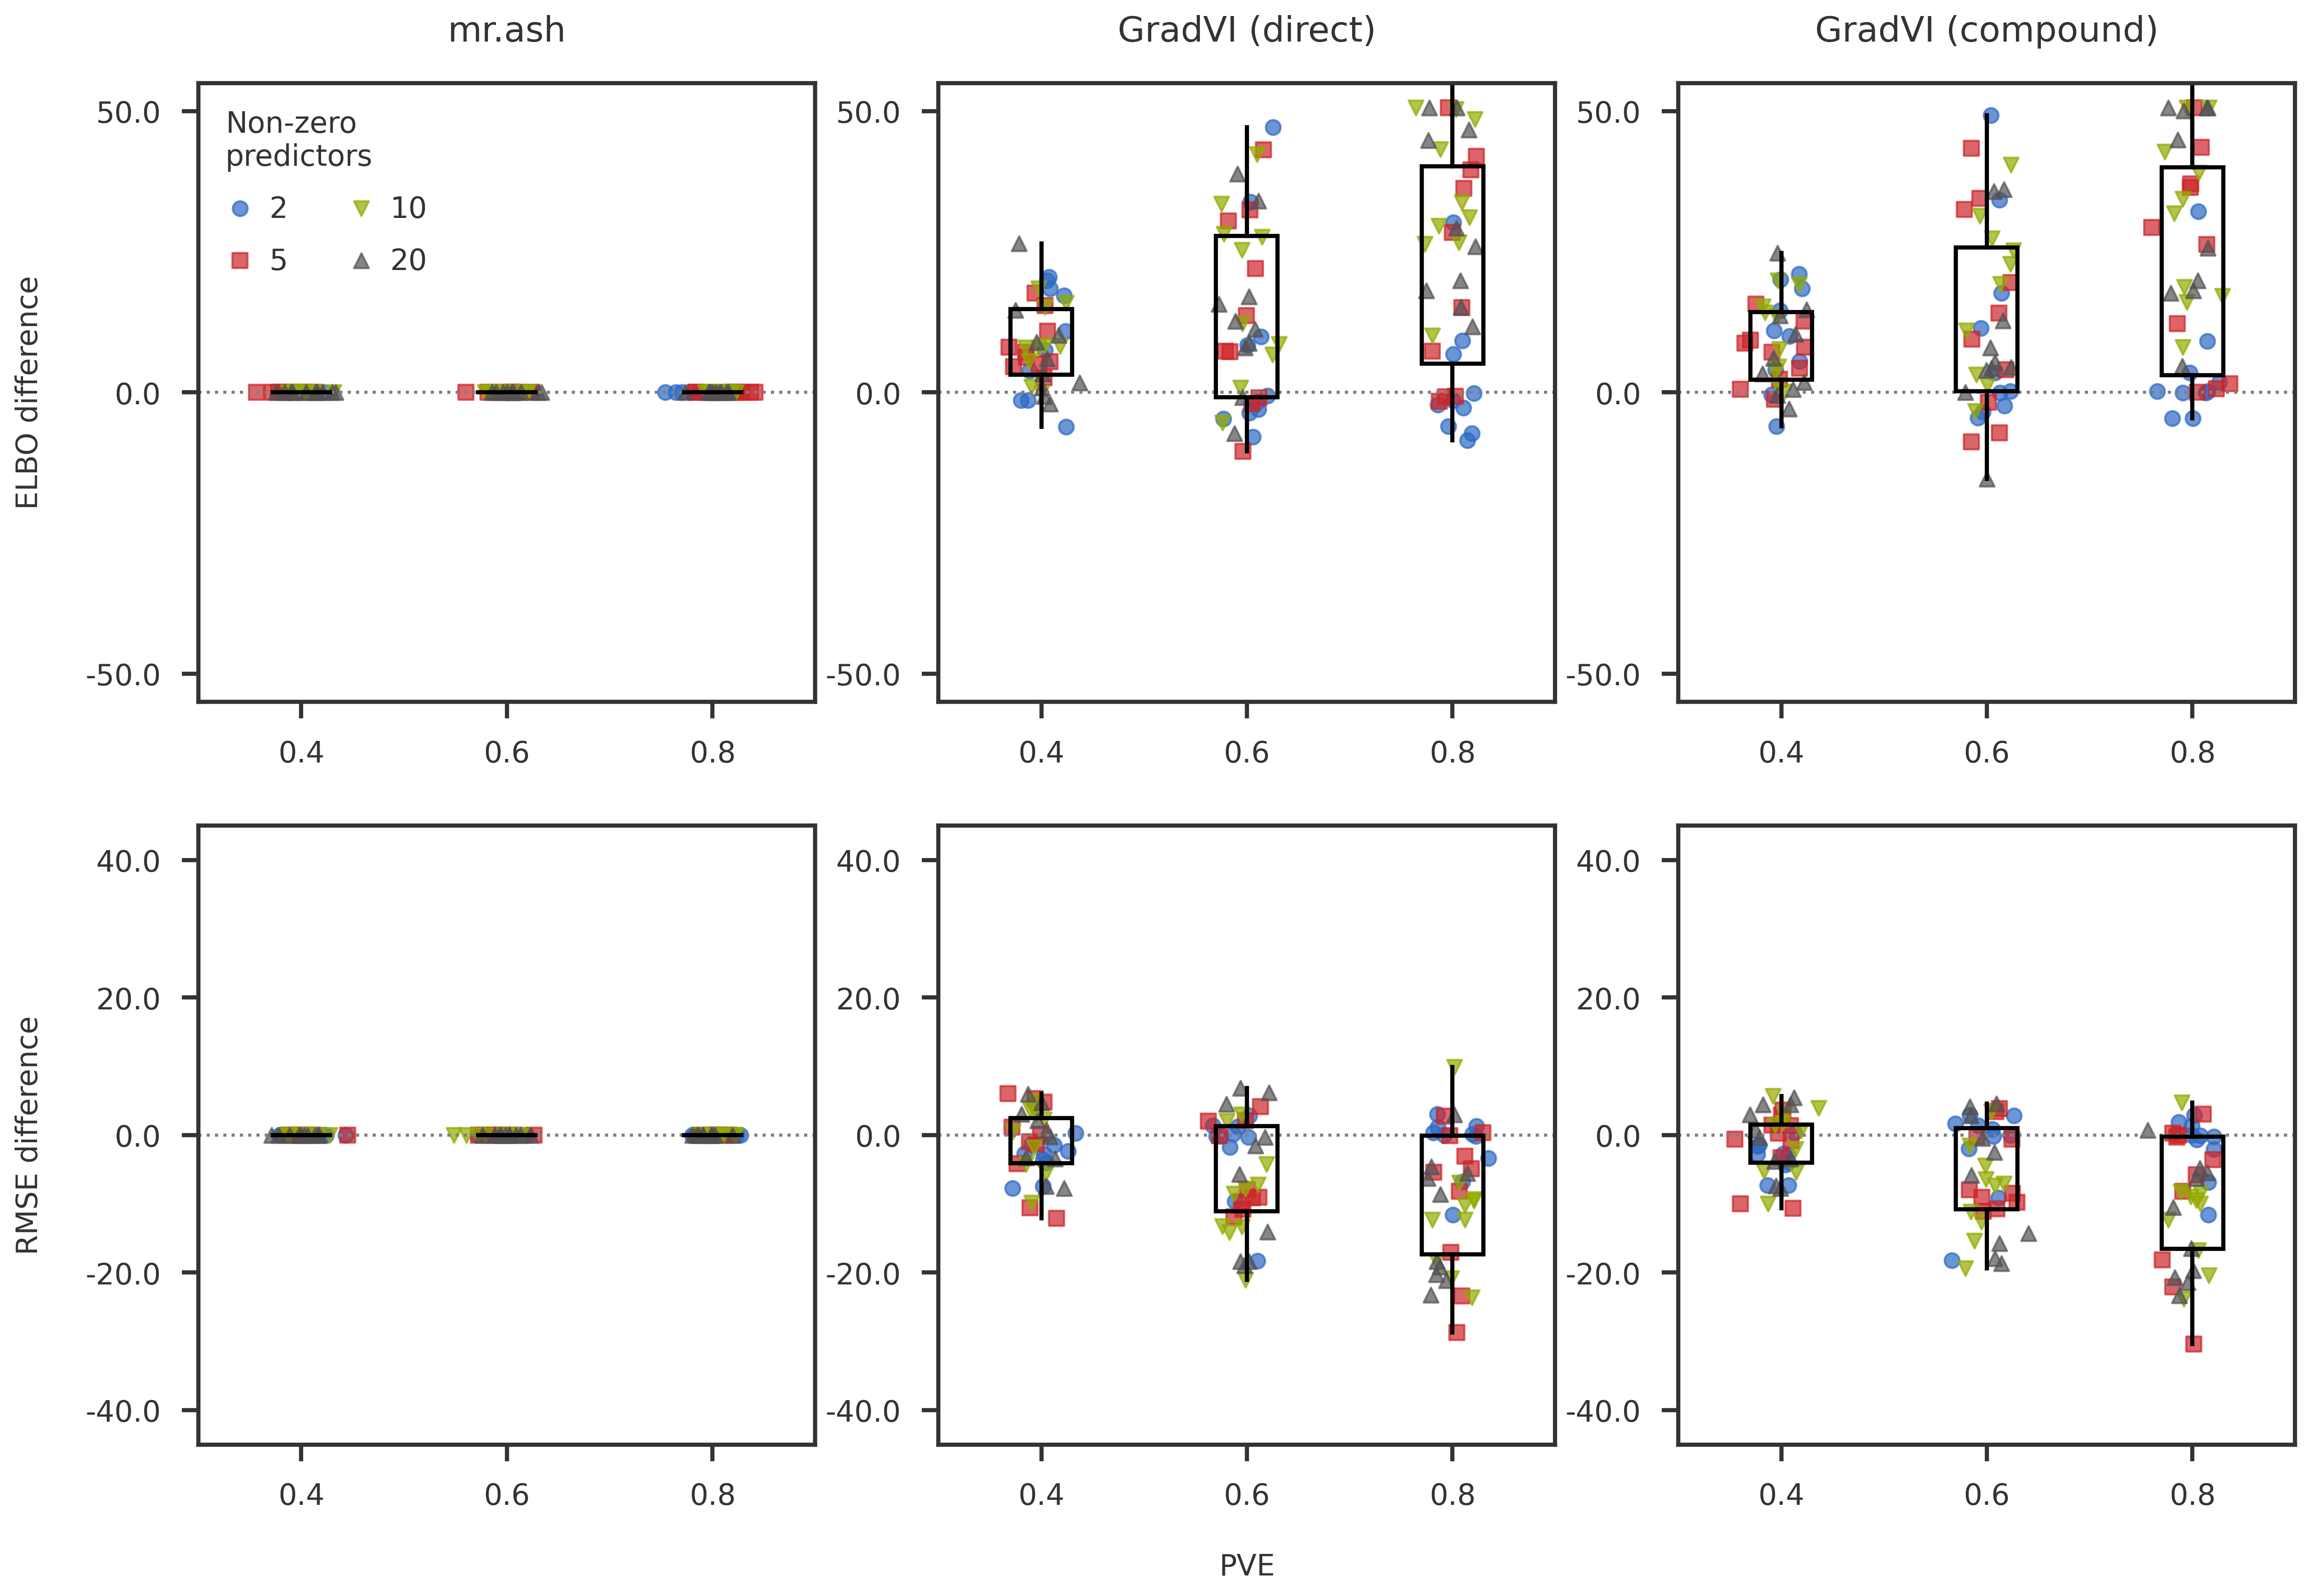

In [24]:
# def np_categorize(arr):
#     unq = np.unique(arr)
#     d1  = {x : i for i, x in enumerate(unq)}
#     d2  = {i : x for i, x in enumerate(unq)}
#     return np.array([d1[x] for x in arr]), d2

# def rand_jitter(arr, d = 0.04):
#     stdev = d * (max(arr) - min(arr))
#     return arr + np.random.randn(len(arr)) * stdev

# def truncate_jitter(arr, ylim, d = 0.04):
#     xnew  = arr.copy()
#     if ylim is not None:
#         ydev  = d * (ylim[1] - ylim[0])
#         ilow  = np.where(xnew < ylim[0] + ydev)[0]
#         ihigh = np.where(xnew > ylim[1] - ydev)[0]
#         if len(ilow) > 0:
#             xnew[ilow]  = ylim[0] + ydev #+ np.abs(np.random.randn(len(ilow))) * ydev
#         if len(ihigh) > 0:
#             xnew[ihigh] = ylim[1] - ydev
#     return xnew

# def match_index(idx1, idx2):
#     return np.intersect1d(idx1, idx2, assume_unique = True)

# def plot_elbo_boxplot(ax, df, reference, target, 
#                       factr = 1, comparison_mode = 'absolute_diff',
#                       has_outliers = False, use_gradvi_alternate = False,
#                       showboxplot = True, showscatter = True, showlegend = True,
#                       ylim = None, debug = False):

#     ref  = factr * df[reference].to_numpy()
#     tgt  = factr * df[target].to_numpy()
#     if comparison_mode == 'absolute_diff':
#         diff = tgt - ref
#     elif comparison_mode == 'percentage_diff':
#         diff = (tgt - ref) * 100 / np.abs(ref)

#     sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
#     pveidx,  pvevals  = np_categorize(df['simulate.pve'].to_numpy())

#     if has_outliers:
#         iremove = np.array([])
#         ikeep   = np.arange(diff.shape[0])
#     else:
#         iremove, ikeep = outlier_index_normal(diff, factor = 10.0)
#         if debug:
#             print (f"Number of outliers removed : {iremove[0].shape[0]}")
#             for i in iremove[0]:
#                 print(f"Index {i},\tPVE={pvevals[pveidx[i]]}, s={sfixvals[sfixidx[i]]}\t diff = {diff[i]:g}")

#     ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
#     if ylim is not None: ax.set_ylim(ylim)
#     xvals = list(pvevals.keys())
#     xlabels = list(pvevals.values())

#     # Box plot for each PVE
#     if showboxplot:
#         boxcolor = '#000000'
#         boxface = f'#{boxcolor[1:]}00' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
#         #boxface = 'white'
#         medianprops = dict(linewidth=0, color = boxcolor)
#         whiskerprops = dict(linewidth=2, color = boxcolor)
#         boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
#         flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)

#         ax.boxplot([diff[match_index(np.where(pveidx == i)[0], ikeep)] for i in xvals],
#                    positions = xvals,
#                    showcaps = False, showfliers = False, 
#                    widths = 0.3, patch_artist = True, notch = False,
#                    flierprops = flierprops, boxprops = boxprops, 
#                    medianprops = medianprops, whiskerprops = whiskerprops)      

#     # Scatter plot with jitter, showing sfix
#     if showscatter:
#         mcolors  = mpl_stylesheet.banskt_colors()
#         mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
#         xpve = rand_jitter(pveidx)
#         diff_trunc = truncate_jitter(diff, ylim)
#         for sidx, sfix in sfixvals.items():
#             marker  = mmarkers[sidx]
#             color   = mcolors[sidx]
#             _idx    = np.where(sfixidx == sidx)[0]
#             _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
#             ax.scatter(xpve[_ikeep], diff_trunc[_ikeep], marker = marker, c = color,
#                        alpha = 0.7, s = 50, linewidth = 1, label = f"{sfix}")
#         # legend for number of causal predictors
#         if showlegend:
#             mhandles, mlabels = ax.get_legend_handles_labels()
#             leg1 = ax.legend(handles = mhandles, labels = mlabels, title = "Non-zero\npredictors",
#                              loc = 'upper left', bbox_to_anchor = (0.02, 0.98), ncol = 2)
#             leg1._legend_box.align = "left"
            
#     ax.set_xticks(xvals)
#     ax.set_xticklabels(xlabels)
#     #mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear', fmt = '{:.1f}')
#     mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear')

# fig = plt.figure(figsize = (18, 12))
# ax1 = fig.add_subplot(231)
# ax2 = fig.add_subplot(232)
# ax3 = fig.add_subplot(233)
# ax4 = fig.add_subplot(234)
# ax5 = fig.add_subplot(235)
# ax6 = fig.add_subplot(236)

# #elbo_ylim = None #[-2.1, 1.2]
# elbo_ylim = [-55, 55]

# #ax1.scatter(rand_jitter(pveidx), diff, alpha = 0.5)
# plot_elbo_boxplot(ax1, elbodf_filtered, 
#                   "mr_ash", "mr_ash", showboxplot = True,
#                   comparison_mode = 'absolute_diff', factr = -1,
#                   has_outliers = True, ylim = elbo_ylim)
# plot_elbo_boxplot(ax2, elbodf_filtered, 
#                   "mr_ash", "gradvi_direct_lasso_init", showlegend = False,
#                   comparison_mode = 'absolute_diff', factr = -1,
#                   has_outliers = True, ylim = elbo_ylim)
# plot_elbo_boxplot(ax3, elbodf_filtered, 
#                   "mr_ash", "gradvi_compound_lasso_init", showlegend = False,
#                   comparison_mode = 'absolute_diff', factr = -1,
#                   has_outliers = True, ylim = elbo_ylim)

# mse_ylim = [-45, 45]
# #mse_ylim = None
# plot_elbo_boxplot(ax4, msedf_filtered,
#                   "mr_ash", "mr_ash", showlegend = False,
#                   comparison_mode = 'percentage_diff',
#                   has_outliers = True, ylim = mse_ylim)
# plot_elbo_boxplot(ax5, msedf_filtered,
#                   "mr_ash", "gradvi_direct_lasso_init", showlegend = False,
#                   comparison_mode = 'percentage_diff',
#                   has_outliers = True, ylim = mse_ylim)
# plot_elbo_boxplot(ax6, msedf_filtered,
#                   "mr_ash", "gradvi_compound_lasso_init", showlegend = False,
#                   comparison_mode = 'percentage_diff',
#                   has_outliers = True, ylim = mse_ylim)


# ax1.set_ylabel(r"ELBO difference")
# ax1.set_title("mr.ash", pad = 20)
# ax2.set_title("GradVI (direct)", pad = 20)
# ax3.set_title("GradVI (compound)", pad = 20)
# ax4.set_ylabel(r"RMSE difference")
# ax5.set_xlabel("PVE")

# #utils.saveplot(fig, plotprefix)
# plt.show()